In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def gaussian_noise(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.3
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

HR_test_path = '/content/gdrive/My Drive/DIV2K/DIV2K_valid_HR'
LR_test_path = '/content/gdrive/My Drive/DIV2K/DIV2K_valid_LR_bicubic/X4'
HR_train_path = '/content/gdrive/My Drive/DIV2K/DIV2K_train_HR'
LR_train_path = '/content/gdrive/My Drive/DIV2K/DIV2K_train_LR_bicubic/X4'  
HR_images = []
LR_images = []


for path in sorted(os.listdir(HR_test_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_valid_HR/' + path)
    img_hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hr = cv2.resize(img_hr,(384,384))
    HR_images.append(img_hr)

for path in sorted(os.listdir(HR_train_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_train_HR/' + path)
    img_hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hr = cv2.resize(img_hr,(384,384))
    HR_images.append(img_hr)

for path in sorted(os.listdir(LR_test_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_valid_LR_bicubic/X4/' + path)
    img_lr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_lr = cv2.GaussianBlur(img_lr, (5,5),0)
    img_lr = cv2.resize(img_lr,(96,96))
    #img_lr = gaussian_noise(img_lr)
    LR_images.append(img_lr)

for path in sorted(os.listdir(LR_train_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_train_LR_bicubic/X4/' + path)
    img_lr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_lr = cv2.GaussianBlur(img_lr, (5,5),0)
    img_lr = cv2.resize(img_lr,(96,96))
    #img_lr = gaussian_noise(img_lr)
    LR_images.append(img_lr)

(-0.5, 95.5, 95.5, -0.5)

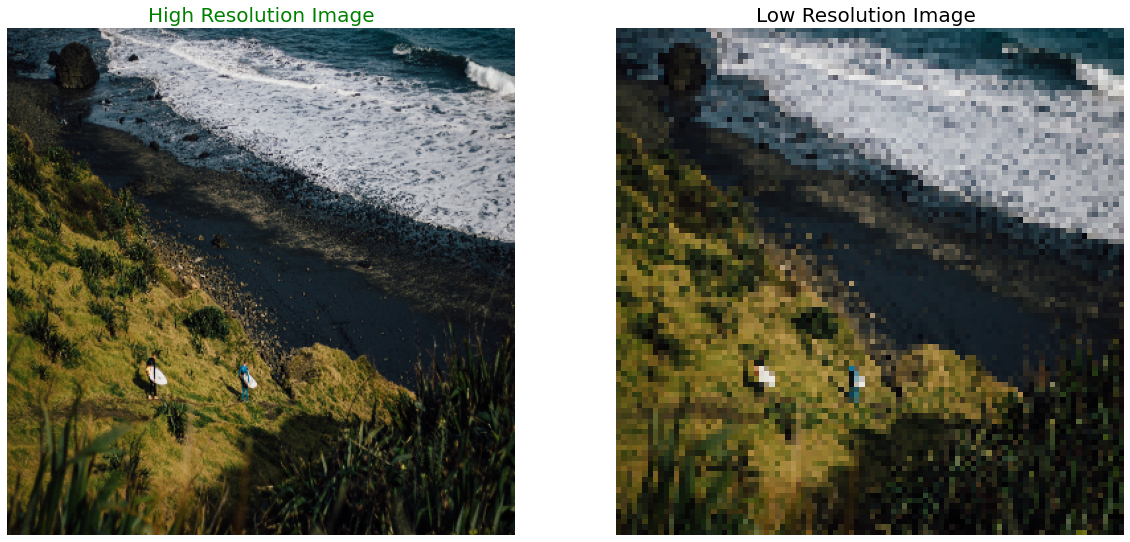

In [ ]:
a = np.random.randint(0,59)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('High Resolution Image', color = 'green', fontsize = 20)
plt.imshow(HR_images[a])
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
plt.imshow(LR_images[a].astype('uint8'))
plt.axis('off')

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
lr_images = np.array(LR_images)
hr_images = np.array(HR_images)

In [ ]:
print(lr_images[0].shape)
print(hr_images[0].shape)

(96, 96, 3)
(384, 384, 3)


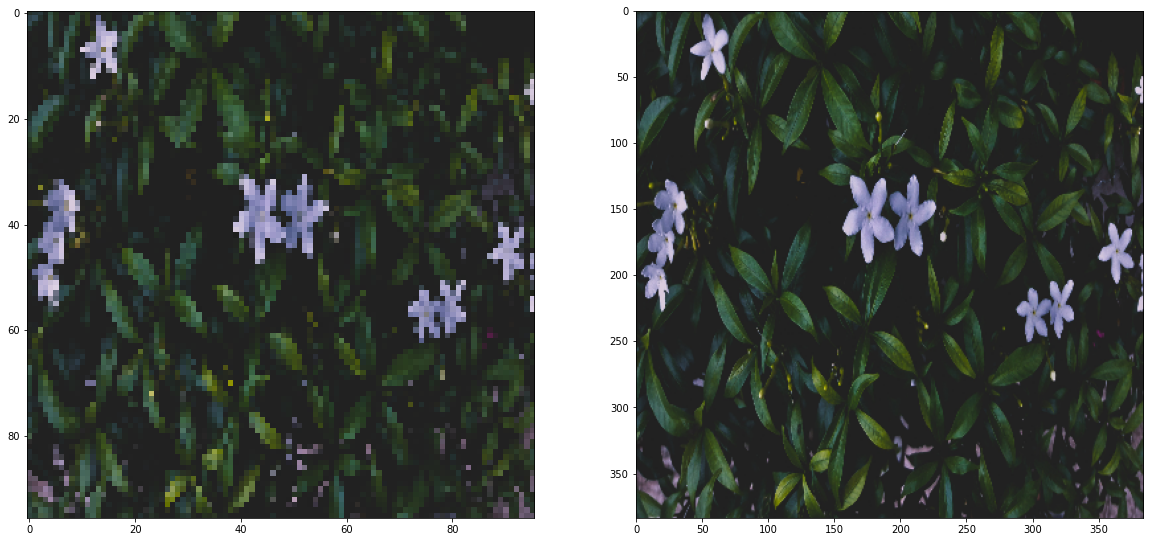

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [ ]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 96, 96, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 384, 384, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 384, 384, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 batch_normalization_33 (Bat  (None, 192, 192, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 192, 192, 64)      0         
                                                           

In [ ]:
vgg = build_vgg((384, 384, 3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                            

In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 384, 384, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            306684737   ['model[0][0]']            

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 8
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 422ms/step


  0%|          | 1/603 [00:22<3:41:05, 22.04s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/603 [00:22<1:34:45,  9.46s/it]

1/1 [==============================] - 0s 15ms/step


  0%|          | 3/603 [00:23<54:21,  5.44s/it]  

1/1 [==============================] - 0s 15ms/step


  1%|          | 4/603 [00:23<35:23,  3.55s/it]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/603 [00:24<24:55,  2.50s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 6/603 [00:25<18:50,  1.89s/it]

1/1 [==============================] - 0s 15ms/step


  1%|          | 7/603 [00:26<14:56,  1.50s/it]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 8/603 [00:26<12:13,  1.23s/it]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 9/603 [00:27<10:24,  1.05s/it]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:28<09:20,  1.06it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/603 [00:28<08:25,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 12/603 [00:29<07:47,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 13/603 [00:30<07:22,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:30<07:03,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:31<06:50,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:31<06:43,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/603 [00:32<06:36,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/603 [00:33<06:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:33<06:28,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 20/603 [00:34<06:31,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 21/603 [00:35<06:30,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 22/603 [00:35<06:26,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:36<06:27,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 24/603 [00:37<06:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 25/603 [00:37<06:24,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:38<06:22,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 27/603 [00:39<06:20,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:39<06:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 29/603 [00:40<06:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 30/603 [00:41<06:16,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 31/603 [00:41<06:16,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:42<06:12,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 33/603 [00:43<06:13,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 34/603 [00:43<06:11,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 35/603 [00:44<06:13,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 36/603 [00:45<06:44,  1.40it/s]

1/1 [==============================] - 0s 74ms/step


  6%|▌         | 37/603 [00:46<07:20,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 38/603 [00:47<07:50,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 39/603 [00:47<07:19,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 40/603 [00:48<06:57,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 41/603 [00:49<06:51,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 42/603 [00:50<06:57,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 43/603 [00:50<06:41,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 44/603 [00:51<06:39,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 45/603 [00:52<06:28,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 46/603 [00:52<06:22,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:53<06:18,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 48/603 [00:54<06:13,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 49/603 [00:54<06:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:55<06:08,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 51/603 [00:56<06:05,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 52/603 [00:56<06:04,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 53/603 [00:57<06:02,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 54/603 [00:57<06:01,  1.52it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▉         | 55/603 [00:58<06:24,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 56/603 [00:59<06:22,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 57/603 [01:00<06:32,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 58/603 [01:00<06:21,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 59/603 [01:01<06:15,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 60/603 [01:02<06:09,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 61/603 [01:02<06:05,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 62/603 [01:03<06:02,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 63/603 [01:04<06:01,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 64/603 [01:04<05:58,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 65/603 [01:05<05:57,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 66/603 [01:06<05:56,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 67/603 [01:06<05:56,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 68/603 [01:07<05:54,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 69/603 [01:08<05:53,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 70/603 [01:08<05:53,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 71/603 [01:09<05:52,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [01:10<05:51,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [01:10<05:50,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 74/603 [01:11<05:49,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 75/603 [01:12<05:49,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [01:12<05:48,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 77/603 [01:13<05:48,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [01:14<05:47,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 79/603 [01:14<05:47,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 80/603 [01:15<05:46,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 81/603 [01:16<05:45,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 82/603 [01:16<05:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [01:17<05:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [01:18<05:44,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 85/603 [01:18<05:50,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 86/603 [01:19<05:48,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 87/603 [01:20<05:50,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [01:20<05:46,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 89/603 [01:21<05:45,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [01:22<05:44,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 91/603 [01:22<05:42,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 92/603 [01:23<05:41,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 93/603 [01:24<05:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:24<05:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:25<05:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 96/603 [01:26<05:38,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:26<05:38,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 98/603 [01:27<05:36,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 99/603 [01:28<05:44,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 100/603 [01:28<05:41,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:29<05:38,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 102/603 [01:30<05:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 103/603 [01:30<05:35,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 104/603 [01:31<05:36,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:32<05:35,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 106/603 [01:32<05:34,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 107/603 [01:33<05:32,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:34<05:31,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 109/603 [01:34<05:30,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 110/603 [01:35<05:29,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 111/603 [01:36<05:28,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 112/603 [01:36<05:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:37<05:27,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:38<05:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/603 [01:38<05:27,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 116/603 [01:39<05:27,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 117/603 [01:40<05:29,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:40<05:28,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 119/603 [01:41<05:33,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 120/603 [01:42<05:29,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 121/603 [01:43<05:27,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 122/603 [01:43<05:24,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 123/603 [01:44<05:25,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:45<05:24,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 125/603 [01:45<05:21,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 126/603 [01:46<05:25,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:47<05:23,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 128/603 [01:47<05:28,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 129/603 [01:48<05:23,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 130/603 [01:49<05:22,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 131/603 [01:49<05:20,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 132/603 [01:50<05:25,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 133/603 [01:51<05:23,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 134/603 [01:51<05:19,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 135/603 [01:52<05:17,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:53<05:16,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:53<05:14,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:54<05:20,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 139/603 [01:55<05:16,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 140/603 [01:55<05:14,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 141/603 [01:56<05:12,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 142/603 [01:57<05:11,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 143/603 [01:58<05:11,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 144/603 [01:58<05:09,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 145/603 [01:59<05:08,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 146/603 [02:00<05:07,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 147/603 [02:00<05:06,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [02:01<05:06,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 149/603 [02:02<05:05,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 150/603 [02:02<05:05,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [02:03<05:05,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 152/603 [02:04<05:04,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 153/603 [02:04<05:04,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 154/603 [02:05<05:11,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 155/603 [02:06<05:17,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 156/603 [02:06<05:16,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 157/603 [02:07<05:36,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 158/603 [02:08<06:11,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 159/603 [02:09<06:03,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 160/603 [02:10<05:45,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [02:10<05:30,  1.34it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 162/603 [02:11<05:20,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 163/603 [02:12<05:12,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 164/603 [02:12<05:07,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 165/603 [02:13<05:03,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 166/603 [02:14<05:00,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [02:15<04:57,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 168/603 [02:15<04:55,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 169/603 [02:16<04:53,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [02:17<04:53,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 171/603 [02:17<05:28,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 172/603 [02:18<05:17,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 173/603 [02:19<05:08,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 174/603 [02:20<05:03,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 175/603 [02:20<05:03,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 176/603 [02:21<04:58,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 177/603 [02:22<04:56,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 178/603 [02:22<04:53,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 179/603 [02:23<04:54,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [02:24<04:57,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 181/603 [02:24<04:52,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 182/603 [02:25<04:55,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:26<04:51,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:26<04:51,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:27<04:48,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 186/603 [02:28<04:45,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:29<04:44,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 188/603 [02:29<04:43,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:30<04:48,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 190/603 [02:31<04:44,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 191/603 [02:31<04:43,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:32<04:41,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 193/603 [02:33<04:40,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 194/603 [02:33<04:38,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 195/603 [02:34<04:37,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 196/603 [02:35<04:37,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 197/603 [02:35<04:35,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 198/603 [02:36<04:35,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 199/603 [02:37<04:34,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 200/603 [02:37<04:33,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 201/603 [02:38<04:33,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 202/603 [02:39<04:33,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 203/603 [02:39<04:32,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:40<04:32,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 205/603 [02:41<04:30,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 206/603 [02:41<04:30,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 207/603 [02:42<04:29,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 208/603 [02:43<04:28,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 209/603 [02:44<04:26,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:44<04:26,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 211/603 [02:45<04:33,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 212/603 [02:46<04:30,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 213/603 [02:46<04:29,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 214/603 [02:47<04:28,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:48<04:26,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 216/603 [02:48<04:26,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/603 [02:49<04:24,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 218/603 [02:50<04:24,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:50<04:22,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 220/603 [02:51<04:23,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 221/603 [02:52<04:21,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:53<04:26,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 223/603 [02:53<04:23,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 224/603 [02:54<04:22,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 225/603 [02:55<04:20,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 226/603 [02:55<04:24,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:56<04:21,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 228/603 [02:57<04:19,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 229/603 [02:57<04:18,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:58<04:18,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 231/603 [02:59<04:15,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 232/603 [02:59<04:15,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 233/603 [03:00<04:14,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [03:01<04:13,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 235/603 [03:01<04:11,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 236/603 [03:02<04:10,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 237/603 [03:03<04:09,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 238/603 [03:04<04:14,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 239/603 [03:04<04:11,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 240/603 [03:05<04:10,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 241/603 [03:06<04:09,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 242/603 [03:06<04:07,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 243/603 [03:07<04:06,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 244/603 [03:08<04:35,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 245/603 [03:09<04:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 246/603 [03:09<04:18,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 247/603 [03:10<04:13,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [03:11<04:09,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 249/603 [03:11<04:08,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 250/603 [03:12<04:06,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 251/603 [03:13<04:04,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 252/603 [03:13<04:01,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 253/603 [03:14<04:00,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 254/603 [03:15<04:00,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 255/603 [03:15<03:58,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 256/603 [03:16<03:57,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 257/603 [03:17<04:02,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 258/603 [03:18<04:29,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 259/603 [03:19<04:18,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/603 [03:19<04:14,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 261/603 [03:20<04:08,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 262/603 [03:21<04:08,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 263/603 [03:21<04:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [03:22<03:59,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 265/603 [03:23<03:56,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 266/603 [03:23<03:54,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 267/603 [03:24<03:52,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [03:25<03:51,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [03:25<03:50,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 270/603 [03:26<03:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [03:27<03:52,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 272/603 [03:28<03:50,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 273/603 [03:28<03:48,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 274/603 [03:29<03:51,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 275/603 [03:30<03:48,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 276/603 [03:30<03:46,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:31<03:44,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:32<03:44,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 279/603 [03:32<03:43,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 280/603 [03:33<03:42,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 281/603 [03:34<03:41,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 282/603 [03:35<03:44,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 283/603 [03:35<03:42,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/603 [03:36<03:41,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 285/603 [03:37<03:43,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:37<03:40,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 287/603 [03:38<03:42,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 288/603 [03:39<03:40,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 289/603 [03:39<03:38,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 290/603 [03:40<03:37,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 291/603 [03:41<03:39,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 292/603 [03:41<03:36,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 293/603 [03:42<03:34,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 294/603 [03:43<03:33,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 295/603 [03:44<03:32,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 296/603 [03:44<03:32,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 297/603 [03:45<03:30,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:46<03:34,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 299/603 [03:46<03:32,  1.43it/s]

1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 300/603 [03:47<03:30,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 301/603 [03:48<03:29,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:49<03:58,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 303/603 [03:49<03:53,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 304/603 [03:50<03:44,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/603 [03:51<03:38,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 306/603 [03:52<03:33,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 307/603 [03:52<03:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 308/603 [03:53<03:30,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 309/603 [03:54<03:27,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 310/603 [03:54<03:27,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 311/603 [03:55<03:27,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 312/603 [03:56<03:25,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:56<03:22,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:57<03:20,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 315/603 [03:58<03:19,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:59<03:18,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 317/603 [03:59<03:17,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 318/603 [04:00<03:17,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 319/603 [04:01<03:15,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 320/603 [04:01<03:15,  1.45it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 321/603 [04:02<03:14,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 322/603 [04:03<03:17,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 323/603 [04:03<03:19,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 324/603 [04:04<03:16,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 325/603 [04:05<03:14,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 326/603 [04:06<03:17,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 327/603 [04:06<03:14,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 328/603 [04:07<03:16,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 329/603 [04:08<03:13,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 330/603 [04:09<03:37,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 331/603 [04:09<03:27,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 332/603 [04:10<03:20,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [04:11<03:18,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 334/603 [04:11<03:13,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [04:12<03:10,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [04:13<03:10,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [04:14<03:08,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 338/603 [04:14<03:06,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 339/603 [04:15<03:28,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [04:16<03:20,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 341/603 [04:17<03:14,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 342/603 [04:17<03:12,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 343/603 [04:18<03:07,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 344/603 [04:19<03:08,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 345/603 [04:19<03:04,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 346/603 [04:20<03:01,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 347/603 [04:21<03:00,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [04:22<03:02,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 349/603 [04:22<03:00,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 350/603 [04:23<03:00,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 351/603 [04:24<03:01,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 352/603 [04:24<02:59,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 353/603 [04:25<02:56,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 354/603 [04:26<02:58,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 355/603 [04:27<02:55,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/603 [04:27<02:53,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 357/603 [04:28<03:11,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 358/603 [04:29<03:04,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 359/603 [04:30<03:01,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 360/603 [04:30<02:56,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 361/603 [04:31<02:53,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 362/603 [04:32<02:53,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 363/603 [04:32<02:53,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 364/603 [04:33<02:50,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:34<02:47,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 366/603 [04:35<03:08,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 367/603 [04:36<02:59,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 368/603 [04:36<02:54,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:37<02:49,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:38<03:05,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 371/603 [04:39<02:59,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:39<02:54,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:40<02:52,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 374/603 [04:41<02:47,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 375/603 [04:41<02:46,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 376/603 [04:42<02:42,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 377/603 [04:43<02:40,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 378/603 [04:44<02:41,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 379/603 [04:44<02:39,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 380/603 [04:45<02:40,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:46<02:37,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:46<02:38,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 383/603 [04:47<02:35,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 384/603 [04:48<02:51,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 385/603 [04:49<02:44,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:49<02:40,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 387/603 [04:50<02:35,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:51<02:35,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 389/603 [04:52<02:32,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 390/603 [04:52<02:33,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 391/603 [04:53<02:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 392/603 [04:54<02:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 393/603 [04:54<02:28,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 394/603 [04:55<02:29,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 395/603 [04:56<02:27,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 396/603 [04:57<02:25,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 397/603 [04:57<02:24,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 398/603 [04:58<02:25,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 399/603 [04:59<02:23,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 400/603 [04:59<02:22,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 401/603 [05:00<02:20,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 402/603 [05:01<02:19,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 403/603 [05:01<02:21,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 404/603 [05:02<02:22,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 405/603 [05:03<02:20,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 406/603 [05:04<02:19,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 407/603 [05:04<02:17,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 408/603 [05:05<02:17,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [05:06<02:16,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 410/603 [05:06<02:14,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 411/603 [05:07<02:13,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 412/603 [05:08<02:14,  1.42it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 413/603 [05:09<02:15,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [05:09<02:13,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 415/603 [05:10<02:12,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 416/603 [05:11<02:12,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 417/603 [05:11<02:10,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 418/603 [05:12<02:09,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 419/603 [05:13<02:08,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 420/603 [05:13<02:07,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 421/603 [05:14<02:09,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 422/603 [05:15<02:07,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/603 [05:16<02:06,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 424/603 [05:16<02:05,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 425/603 [05:17<02:03,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 426/603 [05:18<02:03,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 427/603 [05:18<02:02,  1.43it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 428/603 [05:19<02:01,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 429/603 [05:20<02:03,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 430/603 [05:20<02:01,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [05:21<02:02,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 432/603 [05:22<02:00,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [05:23<01:59,  1.42it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 434/603 [05:23<02:00,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 435/603 [05:24<01:58,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 436/603 [05:25<01:58,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 437/603 [05:25<01:56,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 438/603 [05:26<01:57,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 439/603 [05:27<01:56,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [05:28<01:56,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 441/603 [05:28<01:54,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 442/603 [05:29<01:53,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 443/603 [05:30<01:52,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 444/603 [05:30<01:51,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [05:31<01:53,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [05:32<01:51,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 447/603 [05:33<01:52,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 448/603 [05:33<01:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 449/603 [05:34<01:51,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [05:35<01:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 451/603 [05:35<01:49,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 452/603 [05:36<01:47,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 453/603 [05:37<01:46,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 454/603 [05:38<01:44,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 455/603 [05:38<01:45,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 456/603 [05:39<01:53,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 457/603 [05:40<02:06,  1.15it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 458/603 [05:41<02:04,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 459/603 [05:42<01:57,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:43<01:54,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 461/603 [05:43<01:50,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 462/603 [05:44<01:47,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 463/603 [05:45<01:45,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 464/603 [05:45<01:42,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:46<01:40,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 466/603 [05:47<01:40,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 467/603 [05:48<01:39,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 468/603 [05:48<01:37,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 469/603 [05:49<01:35,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 470/603 [05:50<01:35,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 471/603 [05:51<01:36,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 472/603 [05:51<01:34,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 473/603 [05:52<01:34,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:53<01:32,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 475/603 [05:53<01:30,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/603 [05:54<01:31,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 477/603 [05:55<01:29,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:55<01:28,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:56<01:27,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 480/603 [05:57<01:26,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 481/603 [05:58<01:26,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:58<01:26,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 483/603 [05:59<01:24,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 484/603 [06:00<01:23,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 485/603 [06:00<01:24,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 486/603 [06:01<01:24,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 487/603 [06:02<01:23,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 488/603 [06:03<01:22,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 489/603 [06:03<01:20,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 490/603 [06:04<01:20,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 491/603 [06:05<01:29,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 492/603 [06:06<01:25,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 493/603 [06:06<01:22,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 494/603 [06:07<01:20,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 495/603 [06:08<01:18,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 496/603 [06:09<01:16,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 497/603 [06:09<01:15,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 498/603 [06:10<01:15,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 499/603 [06:11<01:14,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 500/603 [06:12<01:22,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [06:12<01:18,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 502/603 [06:13<01:16,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 503/603 [06:14<01:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 504/603 [06:15<01:13,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 505/603 [06:15<01:11,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:16<01:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [06:17<01:09,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [06:17<01:07,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 509/603 [06:18<01:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 510/603 [06:19<01:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 511/603 [06:20<01:05,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 512/603 [06:20<01:04,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 513/603 [06:21<01:04,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 514/603 [06:22<01:04,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 515/603 [06:22<01:04,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 516/603 [06:23<01:02,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 517/603 [06:24<01:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 518/603 [06:25<01:00,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 519/603 [06:25<00:59,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 520/603 [06:26<00:58,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [06:27<00:57,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 522/603 [06:27<00:57,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 523/603 [06:28<00:56,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [06:29<00:55,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [06:29<00:54,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 526/603 [06:30<00:54,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [06:31<00:53,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 528/603 [06:32<00:53,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 529/603 [06:32<00:52,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 530/603 [06:33<00:51,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 531/603 [06:34<00:51,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 532/603 [06:35<00:51,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 533/603 [06:35<00:49,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 534/603 [06:36<00:49,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 535/603 [06:37<00:48,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 536/603 [06:37<00:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 537/603 [06:38<00:47,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:39<00:47,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 539/603 [06:40<00:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 540/603 [06:40<00:45,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 541/603 [06:41<00:44,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 542/603 [06:42<00:44,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 543/603 [06:42<00:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 544/603 [06:43<00:42,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 545/603 [06:44<00:41,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 546/603 [06:45<00:40,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 547/603 [06:45<00:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:46<00:39,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 549/603 [06:47<00:38,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 550/603 [06:47<00:37,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 551/603 [06:48<00:37,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 552/603 [06:49<00:36,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 553/603 [06:50<00:36,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:50<00:35,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 555/603 [06:51<00:34,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 556/603 [06:52<00:33,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 557/603 [06:52<00:32,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 558/603 [06:53<00:32,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:54<00:31,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 560/603 [06:55<00:30,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 561/603 [06:55<00:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 562/603 [06:56<00:29,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [06:57<00:28,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 564/603 [06:58<00:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 565/603 [06:58<00:27,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 566/603 [06:59<00:26,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [07:00<00:25,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 568/603 [07:00<00:25,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 569/603 [07:01<00:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 570/603 [07:02<00:23,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 571/603 [07:03<00:22,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 572/603 [07:03<00:22,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 573/603 [07:04<00:21,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 574/603 [07:05<00:20,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 575/603 [07:05<00:20,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 576/603 [07:06<00:19,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 577/603 [07:07<00:18,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 578/603 [07:08<00:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 579/603 [07:08<00:17,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 580/603 [07:09<00:16,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 581/603 [07:10<00:15,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 582/603 [07:10<00:14,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 583/603 [07:11<00:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 584/603 [07:12<00:13,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 585/603 [07:13<00:12,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [07:13<00:12,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 587/603 [07:14<00:11,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 588/603 [07:15<00:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 589/603 [07:15<00:10,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 590/603 [07:16<00:09,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 591/603 [07:17<00:08,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 592/603 [07:18<00:07,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [07:18<00:07,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 594/603 [07:19<00:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 595/603 [07:20<00:05,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 596/603 [07:20<00:04,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [07:21<00:04,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 598/603 [07:22<00:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 599/603 [07:23<00:02,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 600/603 [07:23<00:02,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 601/603 [07:24<00:01,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 602/603 [07:25<00:00,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 603/603 [07:25<00:00,  1.35it/s]


epoch: 1 g_loss: 75.02770125608934 d_loss: [15.79902364  0.78772803]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<07:21,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/603 [00:01<07:24,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 3/603 [00:02<07:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 4/603 [00:02<07:19,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/603 [00:03<07:10,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 6/603 [00:04<07:06,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/603 [00:05<07:02,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 8/603 [00:05<07:00,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 9/603 [00:06<06:58,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/603 [00:07<06:57,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 11/603 [00:07<07:01,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 12/603 [00:08<07:04,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:47,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 14/603 [00:10<07:40,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 15/603 [00:11<07:27,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:11<07:15,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 17/603 [00:12<07:07,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 18/603 [00:13<07:09,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 19/603 [00:13<07:00,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/603 [00:14<06:57,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 21/603 [00:15<07:00,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 22/603 [00:16<07:01,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:16<06:54,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 24/603 [00:17<06:52,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 25/603 [00:18<06:59,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:18<06:53,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 27/603 [00:19<06:49,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:20<06:48,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 29/603 [00:20<06:44,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 30/603 [00:21<06:45,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 31/603 [00:22<06:52,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 32/603 [00:23<06:47,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 33/603 [00:23<06:42,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:24<06:42,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 35/603 [00:25<06:40,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 36/603 [00:25<06:45,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/603 [00:26<06:42,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 38/603 [00:27<06:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:28<06:43,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 40/603 [00:28<06:39,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 41/603 [00:29<06:44,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 42/603 [00:30<06:45,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 43/603 [00:31<06:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:31<06:39,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 45/603 [00:32<06:40,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 46/603 [00:33<06:36,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 47/603 [00:33<06:33,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 48/603 [00:34<06:45,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 49/603 [00:35<06:41,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 50/603 [00:36<06:37,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 51/603 [00:36<06:34,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 52/603 [00:37<06:37,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:38<06:33,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 54/603 [00:38<06:35,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 55/603 [00:39<06:33,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 56/603 [00:40<06:28,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 57/603 [00:41<06:34,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 58/603 [00:41<06:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:42<06:28,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 60/603 [00:43<06:33,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 61/603 [00:43<06:28,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/603 [00:44<06:27,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 63/603 [00:45<06:25,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 64/603 [00:46<06:23,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 65/603 [00:46<06:21,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:47<06:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 67/603 [00:48<06:22,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 68/603 [00:48<06:19,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 69/603 [00:49<06:16,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 70/603 [00:50<06:20,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 71/603 [00:51<06:17,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 72/603 [00:51<06:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [00:52<06:13,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 74/603 [00:53<06:19,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 75/603 [00:53<06:21,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 76/603 [00:54<06:23,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 77/603 [00:55<06:18,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:56<06:16,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 79/603 [00:56<06:12,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/603 [00:57<06:10,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 81/603 [00:58<06:08,  1.42it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 82/603 [00:58<06:06,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 83/603 [00:59<06:04,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 84/603 [01:00<06:11,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [01:01<06:15,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 86/603 [01:01<06:17,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 87/603 [01:02<06:18,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 88/603 [01:03<06:13,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 89/603 [01:03<06:14,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 90/603 [01:04<06:14,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 91/603 [01:05<06:09,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 92/603 [01:06<06:11,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 93/603 [01:06<06:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:07<06:02,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:08<05:58,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 96/603 [01:08<05:58,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 97/603 [01:09<06:02,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 98/603 [01:10<06:05,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 99/603 [01:11<06:01,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 100/603 [01:11<06:03,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:12<05:59,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 102/603 [01:13<05:58,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 103/603 [01:14<06:00,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 104/603 [01:14<06:03,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 105/603 [01:15<06:04,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 106/603 [01:16<05:58,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 107/603 [01:17<06:39,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:17<06:23,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 109/603 [01:18<06:17,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 110/603 [01:19<06:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/603 [01:20<06:00,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 112/603 [01:20<05:59,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 113/603 [01:21<05:56,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:22<05:56,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 115/603 [01:22<05:51,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:23<05:48,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:24<05:46,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:25<05:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/603 [01:25<05:45,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 120/603 [01:26<05:44,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:27<05:41,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 122/603 [01:27<05:44,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 123/603 [01:28<05:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:29<05:45,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:30<05:46,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 126/603 [01:30<05:42,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:31<05:39,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 128/603 [01:32<05:37,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 129/603 [01:32<05:35,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 130/603 [01:33<06:17,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 131/603 [01:34<06:04,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 132/603 [01:35<05:53,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/603 [01:36<05:45,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 134/603 [01:36<05:40,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 135/603 [01:37<05:37,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:38<05:38,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 137/603 [01:38<05:45,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/603 [01:39<05:41,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 139/603 [01:40<05:41,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:41<05:35,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 141/603 [01:41<05:31,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 142/603 [01:42<05:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:43<05:30,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 144/603 [01:43<05:27,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:44<05:30,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 146/603 [01:45<06:22,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 147/603 [01:46<06:29,  1.17it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 148/603 [01:47<07:05,  1.07it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:48<06:37,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:49<06:18,  1.20it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 151/603 [01:50<06:01,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 152/603 [01:50<05:51,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 153/603 [01:51<05:44,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 154/603 [01:52<05:36,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 155/603 [01:52<05:35,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 156/603 [01:53<05:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/603 [01:54<05:25,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 158/603 [01:55<05:22,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 159/603 [01:55<05:26,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 160/603 [01:56<05:26,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 161/603 [01:57<05:21,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 162/603 [01:58<05:22,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 163/603 [01:58<05:18,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 164/603 [01:59<05:19,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 165/603 [02:00<05:16,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 166/603 [02:00<05:12,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [02:01<05:10,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 168/603 [02:02<05:10,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 169/603 [02:03<05:11,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 170/603 [02:03<05:14,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/603 [02:04<05:10,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 172/603 [02:05<05:08,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 173/603 [02:05<05:11,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 174/603 [02:06<05:12,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 175/603 [02:07<05:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 176/603 [02:08<05:13,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 177/603 [02:08<05:09,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [02:09<05:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 179/603 [02:10<05:10,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:11<05:09,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 181/603 [02:11<05:05,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 182/603 [02:12<05:01,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:13<04:58,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:13<05:02,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 185/603 [02:14<04:59,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 186/603 [02:15<04:56,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:16<04:54,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 188/603 [02:16<04:57,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:17<04:55,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 190/603 [02:18<04:52,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 191/603 [02:18<04:49,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:19<04:53,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 193/603 [02:20<04:50,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 194/603 [02:21<04:49,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 195/603 [02:21<04:53,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 196/603 [02:22<04:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 197/603 [02:23<04:48,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 198/603 [02:23<04:47,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 199/603 [02:24<04:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 200/603 [02:25<04:47,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 201/603 [02:25<04:44,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 202/603 [02:26<04:47,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 203/603 [02:27<04:46,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:28<04:43,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:28<04:46,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 206/603 [02:29<04:43,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 207/603 [02:30<04:46,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 208/603 [02:31<04:44,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 209/603 [02:31<04:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:32<04:38,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 211/603 [02:33<04:36,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 212/603 [02:33<04:39,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:34<04:42,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 214/603 [02:35<04:39,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:36<04:37,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 216/603 [02:36<04:35,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:37<04:37,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 218/603 [02:38<04:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 219/603 [02:38<04:36,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 220/603 [02:39<04:37,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 221/603 [02:40<04:33,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:41<04:40,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 223/603 [02:41<04:35,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 224/603 [02:42<04:35,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:43<04:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 226/603 [02:44<04:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:44<04:30,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 228/603 [02:45<04:28,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 229/603 [02:46<04:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 230/603 [02:46<04:31,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 231/603 [02:47<04:27,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 232/603 [02:48<04:25,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 233/603 [02:49<04:33,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 234/603 [02:49<04:28,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 235/603 [02:50<04:28,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 236/603 [02:51<04:28,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 237/603 [02:51<04:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 238/603 [02:52<04:21,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 239/603 [02:53<04:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:54<04:20,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:54<04:17,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 242/603 [02:55<04:21,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 243/603 [02:56<04:19,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [02:56<04:16,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 245/603 [02:57<04:18,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 246/603 [02:58<04:43,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 247/603 [02:59<04:36,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 248/603 [03:00<04:28,  1.32it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 249/603 [03:00<04:21,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 250/603 [03:01<04:17,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [03:02<04:15,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 252/603 [03:02<04:13,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 253/603 [03:03<04:14,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 254/603 [03:04<04:42,  1.23it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 255/603 [03:05<04:31,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 256/603 [03:06<04:26,  1.30it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 257/603 [03:06<04:22,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 258/603 [03:07<04:16,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 259/603 [03:08<04:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 260/603 [03:09<04:07,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 261/603 [03:09<04:04,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 262/603 [03:10<04:03,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 263/603 [03:11<04:00,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [03:11<04:05,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 265/603 [03:12<04:03,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/603 [03:13<04:01,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 267/603 [03:14<04:03,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [03:14<04:00,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [03:15<03:58,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 270/603 [03:16<03:56,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 271/603 [03:16<03:58,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 272/603 [03:17<04:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 273/603 [03:18<04:02,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 274/603 [03:19<03:59,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 275/603 [03:19<04:00,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 276/603 [03:20<03:59,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:21<03:56,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 278/603 [03:22<03:56,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/603 [03:22<03:53,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 280/603 [03:23<03:52,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 281/603 [03:24<03:51,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 282/603 [03:24<03:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 283/603 [03:25<03:50,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 284/603 [03:26<03:48,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 285/603 [03:27<03:46,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 286/603 [03:27<03:44,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 287/603 [03:28<03:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 288/603 [03:29<03:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:29<03:45,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 290/603 [03:30<03:43,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 291/603 [03:31<03:45,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:32<03:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 293/603 [03:32<03:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 294/603 [03:33<04:05,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 295/603 [03:34<03:58,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 296/603 [03:35<03:54,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 297/603 [03:35<03:47,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 298/603 [03:36<03:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:37<03:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:38<03:40,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 301/603 [03:38<03:41,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:39<03:37,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:40<03:34,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:40<03:35,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/603 [03:41<03:36,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 306/603 [03:42<03:38,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 307/603 [03:43<03:37,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 308/603 [03:43<03:34,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:44<03:32,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 310/603 [03:45<03:31,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 311/603 [03:46<03:33,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 312/603 [03:46<03:32,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:47<03:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:48<03:30,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 315/603 [03:48<03:30,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 316/603 [03:49<03:26,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/603 [03:50<03:24,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 318/603 [03:51<03:22,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 319/603 [03:51<03:21,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 320/603 [03:52<03:19,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 321/603 [03:53<03:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 322/603 [03:53<03:20,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 323/603 [03:54<03:19,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 324/603 [03:55<03:20,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 325/603 [03:56<03:22,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 326/603 [03:56<03:19,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 327/603 [03:57<03:20,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:58<03:20,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 329/603 [03:59<03:42,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 330/603 [04:00<03:58,  1.14it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 331/603 [04:01<03:46,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 332/603 [04:01<03:38,  1.24it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 333/603 [04:02<03:30,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [04:03<03:26,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 335/603 [04:03<03:20,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [04:04<03:16,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [04:05<03:15,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 338/603 [04:06<03:13,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 339/603 [04:06<03:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 340/603 [04:07<03:11,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 341/603 [04:08<03:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 342/603 [04:08<03:07,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 343/603 [04:09<03:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [04:10<03:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 345/603 [04:11<03:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 346/603 [04:11<03:04,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 347/603 [04:12<03:02,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 348/603 [04:13<03:04,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 349/603 [04:14<03:01,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 350/603 [04:14<03:02,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 351/603 [04:15<03:00,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 352/603 [04:16<03:05,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 353/603 [04:16<03:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 354/603 [04:17<03:00,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 355/603 [04:18<03:00,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 356/603 [04:19<02:57,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 357/603 [04:19<02:56,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 358/603 [04:20<02:54,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 359/603 [04:21<02:53,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [04:21<02:52,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 361/603 [04:22<02:54,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 362/603 [04:23<02:54,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 363/603 [04:24<02:52,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 364/603 [04:24<02:52,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:25<02:51,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 366/603 [04:26<02:51,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 367/603 [04:26<02:49,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 368/603 [04:27<02:48,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 369/603 [04:28<02:46,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 370/603 [04:29<02:45,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 371/603 [04:29<02:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:30<02:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 373/603 [04:31<02:45,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:32<02:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 375/603 [04:32<02:44,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:33<02:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:34<02:44,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 378/603 [04:34<02:44,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 379/603 [04:35<02:42,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 380/603 [04:36<02:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:37<02:40,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:37<02:38,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 383/603 [04:38<02:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 384/603 [04:39<02:37,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 385/603 [04:39<02:35,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:40<02:36,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 387/603 [04:41<02:35,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:42<02:33,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 389/603 [04:42<02:33,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:43<02:33,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:44<02:34,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 392/603 [04:45<02:32,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 393/603 [04:45<02:32,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 394/603 [04:46<02:30,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 395/603 [04:47<02:28,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 396/603 [04:47<02:27,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:48<02:28,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 398/603 [04:49<02:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:50<02:26,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 400/603 [04:50<02:25,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 401/603 [04:51<02:26,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 402/603 [04:52<02:24,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 403/603 [04:52<02:23,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 404/603 [04:53<02:21,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 405/603 [04:54<02:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 406/603 [04:55<02:20,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 407/603 [04:55<02:21,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 408/603 [04:56<02:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 409/603 [04:57<02:20,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 410/603 [04:57<02:18,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 411/603 [04:58<02:17,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 412/603 [04:59<02:16,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [05:00<02:14,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [05:00<02:15,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 415/603 [05:01<02:16,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 416/603 [05:02<02:14,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 417/603 [05:02<02:12,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 418/603 [05:03<02:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 419/603 [05:04<02:11,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 420/603 [05:05<02:10,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 421/603 [05:05<02:10,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 422/603 [05:06<02:09,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/603 [05:07<02:24,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 424/603 [05:08<02:17,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 425/603 [05:09<02:15,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 426/603 [05:09<02:16,  1.30it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 427/603 [05:10<02:14,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [05:11<02:12,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 429/603 [05:11<02:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [05:12<02:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [05:13<02:04,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 432/603 [05:14<02:03,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 433/603 [05:14<02:03,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 434/603 [05:15<02:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 435/603 [05:16<02:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 436/603 [05:17<02:02,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 437/603 [05:18<02:19,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 438/603 [05:18<02:15,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 439/603 [05:20<02:26,  1.12it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [05:20<02:16,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 441/603 [05:21<02:10,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [05:22<02:04,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 443/603 [05:22<02:00,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 444/603 [05:23<01:57,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [05:24<01:55,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 446/603 [05:24<01:53,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 447/603 [05:25<01:52,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 448/603 [05:26<01:52,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 449/603 [05:27<01:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 450/603 [05:27<01:49,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 451/603 [05:28<01:48,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 452/603 [05:29<01:49,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 453/603 [05:30<01:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 454/603 [05:30<01:48,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 455/603 [05:31<01:48,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 456/603 [05:32<01:48,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:33<01:48,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 458/603 [05:33<01:45,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 459/603 [05:34<01:45,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 460/603 [05:35<01:45,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 461/603 [05:35<01:43,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 462/603 [05:36<01:43,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 463/603 [05:37<01:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 464/603 [05:38<01:41,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:38<01:39,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 466/603 [05:39<01:38,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 467/603 [05:40<01:37,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 468/603 [05:40<01:36,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 469/603 [05:41<01:36,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 470/603 [05:42<01:35,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 471/603 [05:43<01:34,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:43<01:33,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 473/603 [05:44<01:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 474/603 [05:45<01:32,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 475/603 [05:45<01:30,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:46<01:30,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 477/603 [05:47<01:29,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:48<01:29,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:48<01:28,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 480/603 [05:49<01:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 481/603 [05:50<01:28,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 482/603 [05:51<01:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:51<01:26,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 484/603 [05:52<01:25,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 485/603 [05:53<01:24,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 486/603 [05:53<01:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/603 [05:54<01:25,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 488/603 [05:55<01:23,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 489/603 [05:56<01:23,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 490/603 [05:56<01:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [05:57<01:20,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 492/603 [05:58<01:20,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:58<01:20,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 494/603 [05:59<01:19,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 495/603 [06:00<01:19,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 496/603 [06:01<01:17,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 497/603 [06:02<01:24,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 498/603 [06:02<01:22,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/603 [06:03<01:19,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 500/603 [06:04<01:17,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 501/603 [06:05<01:16,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 502/603 [06:06<01:22,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [06:06<01:19,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 504/603 [06:07<01:15,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 505/603 [06:08<01:13,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:08<01:12,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 507/603 [06:09<01:10,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [06:10<01:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 509/603 [06:11<01:08,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 510/603 [06:11<01:07,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 511/603 [06:12<01:05,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 512/603 [06:13<01:06,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 513/603 [06:14<01:05,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 514/603 [06:14<01:05,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 515/603 [06:15<01:05,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 516/603 [06:16<01:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 517/603 [06:17<01:09,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 518/603 [06:18<01:12,  1.17it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 519/603 [06:18<01:07,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 520/603 [06:19<01:04,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 521/603 [06:20<01:02,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 522/603 [06:20<01:00,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 523/603 [06:21<00:58,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [06:22<00:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [06:23<00:56,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 526/603 [06:23<00:55,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 527/603 [06:24<00:54,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 528/603 [06:25<00:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 529/603 [06:25<00:53,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [06:26<00:52,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 531/603 [06:27<00:51,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 532/603 [06:28<00:51,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 533/603 [06:28<00:51,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [06:29<00:50,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 535/603 [06:30<00:49,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 536/603 [06:31<00:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 537/603 [06:31<00:47,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 538/603 [06:32<00:46,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [06:33<00:45,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 540/603 [06:33<00:45,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [06:34<00:44,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 542/603 [06:35<00:44,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 543/603 [06:36<00:43,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 544/603 [06:36<00:42,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 545/603 [06:37<00:41,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 546/603 [06:38<00:40,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 547/603 [06:38<00:40,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 548/603 [06:39<00:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:40<00:38,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 550/603 [06:41<00:38,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 551/603 [06:41<00:37,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 552/603 [06:42<00:37,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 553/603 [06:43<00:36,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 554/603 [06:44<00:35,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 555/603 [06:44<00:34,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 556/603 [06:45<00:33,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 557/603 [06:46<00:32,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 558/603 [06:46<00:31,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 559/603 [06:47<00:31,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 560/603 [06:48<00:30,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:49<00:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 562/603 [06:49<00:29,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 563/603 [06:50<00:29,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 564/603 [06:51<00:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 565/603 [06:51<00:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 566/603 [06:52<00:26,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 567/603 [06:53<00:26,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 568/603 [06:54<00:25,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 569/603 [06:54<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 570/603 [06:55<00:23,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 571/603 [06:56<00:23,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 572/603 [06:56<00:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 573/603 [06:57<00:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 574/603 [06:58<00:20,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 575/603 [06:59<00:20,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 576/603 [06:59<00:19,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 577/603 [07:00<00:18,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 578/603 [07:01<00:18,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 579/603 [07:02<00:17,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 580/603 [07:02<00:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 581/603 [07:03<00:15,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 582/603 [07:04<00:15,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 583/603 [07:04<00:14,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 584/603 [07:05<00:13,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 585/603 [07:06<00:12,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 586/603 [07:07<00:12,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [07:07<00:11,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 588/603 [07:08<00:10,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [07:09<00:09,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 590/603 [07:09<00:09,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 591/603 [07:10<00:08,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 592/603 [07:11<00:07,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 593/603 [07:12<00:07,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 594/603 [07:12<00:06,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 595/603 [07:13<00:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 596/603 [07:14<00:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 597/603 [07:14<00:04,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 598/603 [07:15<00:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 599/603 [07:16<00:02,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 600/603 [07:17<00:02,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 601/603 [07:17<00:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [07:18<00:00,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 603/603 [07:19<00:00,  1.37it/s]


epoch: 2 g_loss: 53.445050380320886 d_loss: [4.79653001 0.78026534]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<07:24,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/603 [00:01<07:14,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 3/603 [00:02<07:21,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/603 [00:02<07:14,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/603 [00:03<07:14,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 6/603 [00:04<07:09,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:05<07:14,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 8/603 [00:05<07:09,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 9/603 [00:06<07:11,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:07<07:17,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/603 [00:08<07:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 12/603 [00:08<07:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:09,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/603 [00:10<07:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 15/603 [00:10<07:06,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/603 [00:11<07:01,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 17/603 [00:12<07:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 18/603 [00:13<07:06,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 19/603 [00:13<07:00,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/603 [00:14<07:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 21/603 [00:15<06:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 22/603 [00:15<07:02,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:16<06:58,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 24/603 [00:17<06:56,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 25/603 [00:18<06:54,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:18<06:55,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 27/603 [00:19<06:51,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 28/603 [00:20<06:50,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 29/603 [00:20<06:48,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 30/603 [00:21<06:52,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 31/603 [00:22<06:51,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 32/603 [00:23<06:48,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 33/603 [00:23<06:46,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 34/603 [00:24<06:44,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 35/603 [00:25<06:41,  1.41it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 36/603 [00:25<06:41,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:26<06:41,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 38/603 [00:27<06:38,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 39/603 [00:28<06:39,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 40/603 [00:29<07:22,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 41/603 [00:29<07:06,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 42/603 [00:30<07:03,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 43/603 [00:31<07:02,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:31<06:58,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 45/603 [00:32<06:50,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 46/603 [00:33<06:45,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 47/603 [00:34<06:41,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 48/603 [00:34<06:45,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:35<06:46,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 50/603 [00:36<06:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 51/603 [00:37<06:36,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 52/603 [00:37<06:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 53/603 [00:38<06:35,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 54/603 [00:39<06:32,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 55/603 [00:39<06:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 56/603 [00:40<06:34,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 57/603 [00:41<06:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 58/603 [00:42<06:34,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 59/603 [00:42<06:32,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 60/603 [00:43<06:29,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 61/603 [00:44<06:26,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 62/603 [00:44<06:30,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 63/603 [00:45<06:26,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 64/603 [00:46<06:29,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 65/603 [00:47<06:27,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 66/603 [00:47<06:24,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 67/603 [00:48<06:26,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 68/603 [00:49<06:26,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 69/603 [00:49<06:24,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 70/603 [00:50<06:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/603 [00:51<06:20,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 72/603 [00:52<06:30,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [00:52<06:25,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 74/603 [00:53<06:21,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 75/603 [00:54<06:19,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [00:54<06:15,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 77/603 [00:55<06:19,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 78/603 [00:56<06:16,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 79/603 [00:57<06:15,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 80/603 [00:57<06:14,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 81/603 [00:58<06:16,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 82/603 [00:59<06:17,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [01:00<06:14,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [01:00<06:10,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [01:01<06:10,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 86/603 [01:02<06:09,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 87/603 [01:02<06:07,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [01:03<06:05,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 89/603 [01:04<06:03,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [01:04<06:01,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 91/603 [01:05<06:05,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 92/603 [01:06<06:08,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 93/603 [01:07<06:05,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 94/603 [01:07<06:04,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 95/603 [01:08<06:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 96/603 [01:09<06:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:10<06:02,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 98/603 [01:10<06:00,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 99/603 [01:11<05:59,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 100/603 [01:12<05:57,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 101/603 [01:12<05:56,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 102/603 [01:13<05:55,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 103/603 [01:14<05:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 104/603 [01:15<05:57,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 105/603 [01:15<05:59,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 106/603 [01:16<06:01,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 107/603 [01:17<05:57,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 108/603 [01:17<05:54,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 109/603 [01:18<05:52,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 110/603 [01:19<05:55,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 111/603 [01:20<05:56,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:20<05:58,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 113/603 [01:21<05:56,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:22<05:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 115/603 [01:22<05:51,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 116/603 [01:23<05:48,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 117/603 [01:24<05:51,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 118/603 [01:25<05:52,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 119/603 [01:25<05:49,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 120/603 [01:26<05:47,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:27<05:49,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 122/603 [01:28<05:50,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 123/603 [01:28<05:47,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:29<05:45,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 125/603 [01:30<06:06,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 126/603 [01:31<06:52,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 127/603 [01:32<06:51,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 128/603 [01:33<06:31,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:33<06:14,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 130/603 [01:34<06:01,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 131/603 [01:35<05:50,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 132/603 [01:35<05:45,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 133/603 [01:36<05:40,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/603 [01:37<05:43,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 135/603 [01:38<05:39,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:38<05:40,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 137/603 [01:39<05:37,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 138/603 [01:40<05:39,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 139/603 [01:40<05:40,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 140/603 [01:41<05:37,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 141/603 [01:42<05:33,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 142/603 [01:43<05:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:43<05:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:44<05:29,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 145/603 [01:45<05:28,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 146/603 [01:46<05:32,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 147/603 [01:46<05:38,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:47<05:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:48<05:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 150/603 [01:48<05:25,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 151/603 [01:49<05:22,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:50<05:31,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 153/603 [01:51<05:30,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 154/603 [01:51<05:30,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 155/603 [01:52<05:29,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 156/603 [01:53<05:31,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 157/603 [01:54<05:29,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 158/603 [01:54<05:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 159/603 [01:55<05:24,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 160/603 [01:56<05:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:56<05:17,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 162/603 [01:57<05:16,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 163/603 [01:58<05:19,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 164/603 [01:59<05:16,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 165/603 [01:59<05:13,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 166/603 [02:00<05:15,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 167/603 [02:01<05:51,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 168/603 [02:02<05:41,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 169/603 [02:03<05:34,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 170/603 [02:03<05:29,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/603 [02:04<05:26,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 172/603 [02:05<05:18,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 173/603 [02:05<05:18,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 174/603 [02:06<05:13,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 175/603 [02:07<05:10,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 176/603 [02:08<05:11,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 177/603 [02:08<05:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 178/603 [02:09<05:04,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 179/603 [02:10<05:06,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:10<05:02,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 181/603 [02:11<05:01,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 182/603 [02:12<05:00,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:13<04:59,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:13<05:02,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:14<05:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 186/603 [02:15<05:05,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 187/603 [02:16<05:01,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 188/603 [02:16<04:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:17<05:32,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 190/603 [02:18<05:20,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 191/603 [02:19<05:10,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:19<05:11,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 193/603 [02:20<05:05,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 194/603 [02:21<05:04,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 195/603 [02:22<05:02,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 196/603 [02:22<05:03,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 197/603 [02:23<04:57,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 198/603 [02:24<04:57,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 199/603 [02:25<04:57,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 200/603 [02:25<04:54,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 201/603 [02:26<04:51,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 202/603 [02:27<04:48,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 203/603 [02:27<04:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:28<04:45,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:29<04:47,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:30<04:45,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 207/603 [02:30<04:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 208/603 [02:31<04:45,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 209/603 [02:32<04:43,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 210/603 [02:32<04:43,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 211/603 [02:33<04:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 212/603 [02:34<04:41,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 213/603 [02:35<04:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:35<04:40,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 215/603 [02:36<04:38,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 216/603 [02:37<04:40,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 217/603 [02:38<04:39,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 218/603 [02:38<04:37,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 219/603 [02:39<04:35,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 220/603 [02:40<04:32,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:40<04:32,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:41<04:31,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:42<04:31,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 224/603 [02:43<04:31,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 225/603 [02:43<04:29,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 226/603 [02:44<04:28,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 227/603 [02:45<04:28,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/603 [02:45<04:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 229/603 [02:46<04:28,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 230/603 [02:47<04:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 231/603 [02:48<04:28,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 232/603 [02:48<04:27,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:49<04:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/603 [02:50<04:25,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 235/603 [02:50<04:23,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 236/603 [02:51<04:21,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 237/603 [02:52<04:20,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 238/603 [02:53<04:18,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 239/603 [02:53<04:21,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 240/603 [02:54<04:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:55<04:23,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 242/603 [02:55<04:20,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 243/603 [02:56<04:18,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 244/603 [02:57<04:19,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 245/603 [02:58<04:20,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 246/603 [02:58<04:21,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 247/603 [02:59<04:18,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [03:00<04:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [03:01<04:18,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 250/603 [03:01<04:17,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 251/603 [03:02<04:19,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [03:03<04:19,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 253/603 [03:04<04:19,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 254/603 [03:04<04:18,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 255/603 [03:05<04:14,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 256/603 [03:06<04:14,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 257/603 [03:06<04:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/603 [03:07<04:11,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 259/603 [03:08<04:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 260/603 [03:09<04:08,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 261/603 [03:09<04:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 262/603 [03:10<04:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 263/603 [03:11<04:05,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 264/603 [03:11<04:03,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 265/603 [03:12<04:06,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 266/603 [03:13<04:03,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/603 [03:14<04:01,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [03:14<03:59,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 269/603 [03:15<03:58,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [03:16<03:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [03:17<03:57,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 272/603 [03:17<03:56,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 273/603 [03:18<03:55,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 274/603 [03:19<03:53,  1.41it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 275/603 [03:19<03:53,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 276/603 [03:20<03:52,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:21<03:53,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:22<04:21,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 279/603 [03:23<04:10,  1.30it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 280/603 [03:23<04:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 281/603 [03:24<04:00,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 282/603 [03:25<03:56,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 283/603 [03:25<03:55,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 284/603 [03:26<03:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 285/603 [03:27<03:52,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 286/603 [03:28<03:50,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:28<03:50,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 288/603 [03:29<03:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 289/603 [03:30<03:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 290/603 [03:31<03:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:31<03:47,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 292/603 [03:32<03:43,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 293/603 [03:33<03:42,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 294/603 [03:33<03:43,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 295/603 [03:34<03:41,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 296/603 [03:35<03:42,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 297/603 [03:36<03:43,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:37<04:07,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:37<03:56,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 300/603 [03:38<03:55,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 301/603 [03:39<03:49,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:39<03:43,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 303/603 [03:40<03:41,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:41<03:38,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 305/603 [03:42<03:39,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 306/603 [03:42<03:38,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 307/603 [03:43<03:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 308/603 [03:44<03:36,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:45<03:36,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 310/603 [03:45<03:34,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 311/603 [03:46<03:34,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:47<03:36,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:48<03:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:48<03:32,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 315/603 [03:49<03:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:50<03:32,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 317/603 [03:50<03:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:51<03:29,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 319/603 [03:52<03:29,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 320/603 [03:53<03:26,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 321/603 [03:53<03:23,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:54<03:24,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 323/603 [03:55<03:25,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 324/603 [03:56<03:25,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 325/603 [03:56<03:25,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 326/603 [03:57<03:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [03:58<03:19,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:58<03:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 329/603 [03:59<03:17,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 330/603 [04:00<03:15,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [04:01<03:16,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 332/603 [04:01<03:17,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 333/603 [04:02<03:14,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 334/603 [04:03<03:34,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [04:04<03:28,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/603 [04:05<03:23,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 337/603 [04:05<03:21,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 338/603 [04:06<03:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [04:07<03:15,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 340/603 [04:07<03:15,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 341/603 [04:08<03:11,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 342/603 [04:09<03:11,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 343/603 [04:10<03:12,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 344/603 [04:10<03:11,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 345/603 [04:11<03:09,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 346/603 [04:12<03:07,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 347/603 [04:13<03:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [04:13<03:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 349/603 [04:14<03:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 350/603 [04:15<03:03,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 351/603 [04:16<03:04,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 352/603 [04:16<03:01,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 353/603 [04:17<03:00,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 354/603 [04:18<02:58,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 355/603 [04:18<02:59,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 356/603 [04:19<03:01,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 357/603 [04:20<02:59,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 358/603 [04:21<02:57,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/603 [04:21<02:56,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [04:22<02:53,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 361/603 [04:23<02:52,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 362/603 [04:23<02:57,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 363/603 [04:24<02:54,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 364/603 [04:25<02:54,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 365/603 [04:26<02:55,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 366/603 [04:26<02:54,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 367/603 [04:27<02:54,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 368/603 [04:28<02:51,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:29<02:49,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:29<02:47,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 371/603 [04:30<02:45,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:31<02:47,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 373/603 [04:31<02:47,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:32<02:45,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 375/603 [04:33<02:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:34<02:47,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 377/603 [04:34<02:44,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 378/603 [04:35<02:43,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 379/603 [04:36<02:42,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:37<02:40,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:37<02:40,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 382/603 [04:38<02:40,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 383/603 [04:39<02:38,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 384/603 [04:39<02:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:40<02:38,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 386/603 [04:41<02:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 387/603 [04:42<02:36,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:42<02:34,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 389/603 [04:43<02:38,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:44<02:35,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:45<02:37,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 392/603 [04:45<02:35,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 393/603 [04:46<02:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 394/603 [04:47<02:31,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 395/603 [04:47<02:31,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 396/603 [04:48<02:31,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 397/603 [04:49<02:28,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 398/603 [04:50<02:27,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 399/603 [04:50<02:26,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 400/603 [04:51<02:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:52<02:25,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:53<02:25,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 403/603 [04:53<02:24,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 404/603 [04:54<02:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:55<02:22,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 406/603 [04:55<02:21,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 407/603 [04:56<02:21,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 408/603 [04:57<02:19,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 409/603 [04:58<02:20,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 410/603 [04:58<02:20,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 411/603 [04:59<02:37,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 412/603 [05:00<02:35,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 413/603 [05:01<02:31,  1.26it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 414/603 [05:02<02:31,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 415/603 [05:02<02:26,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 416/603 [05:03<02:21,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 417/603 [05:04<02:20,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 418/603 [05:05<02:17,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 419/603 [05:05<02:15,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 420/603 [05:06<02:12,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 421/603 [05:07<02:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 422/603 [05:07<02:10,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 423/603 [05:08<02:09,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [05:09<02:08,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 425/603 [05:10<02:08,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 426/603 [05:10<02:07,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 427/603 [05:11<02:06,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [05:12<02:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 429/603 [05:13<02:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [05:13<02:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [05:14<02:04,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 432/603 [05:15<02:04,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 433/603 [05:15<02:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 434/603 [05:16<02:02,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 435/603 [05:17<02:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [05:18<02:00,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 437/603 [05:18<02:00,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 438/603 [05:19<02:00,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 439/603 [05:20<01:59,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 440/603 [05:21<01:59,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 441/603 [05:21<01:57,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 442/603 [05:22<01:56,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 443/603 [05:23<01:55,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 444/603 [05:23<01:55,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [05:24<01:55,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 446/603 [05:25<01:55,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 447/603 [05:26<01:53,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 448/603 [05:26<01:51,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 449/603 [05:27<01:50,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [05:28<01:50,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 451/603 [05:29<01:50,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 452/603 [05:29<01:49,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 453/603 [05:30<01:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 454/603 [05:31<01:47,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 455/603 [05:31<01:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 456/603 [05:32<01:46,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:33<01:44,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 458/603 [05:34<01:44,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 459/603 [05:34<01:43,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:35<01:41,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 461/603 [05:36<01:40,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 462/603 [05:36<01:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 463/603 [05:37<01:40,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 464/603 [05:38<01:39,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:39<01:39,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 466/603 [05:39<01:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 467/603 [05:40<01:39,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:41<01:38,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 469/603 [05:42<01:38,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 470/603 [05:42<01:37,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 471/603 [05:43<01:36,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:44<01:34,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 473/603 [05:44<01:34,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 474/603 [05:45<01:32,  1.39it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 475/603 [05:46<01:32,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/603 [05:47<01:31,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 477/603 [05:47<01:31,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 478/603 [05:48<01:30,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:49<01:30,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 480/603 [05:49<01:28,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 481/603 [05:50<01:27,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 482/603 [05:51<01:27,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 483/603 [05:52<01:27,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 484/603 [05:52<01:26,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 485/603 [05:53<01:25,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:54<01:24,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 487/603 [05:55<01:24,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 488/603 [05:55<01:23,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 489/603 [05:56<01:21,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 490/603 [05:57<01:21,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [05:57<01:20,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 492/603 [05:58<01:20,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 493/603 [05:59<01:20,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 494/603 [06:00<01:20,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 495/603 [06:00<01:19,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [06:01<01:17,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 497/603 [06:02<01:18,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 498/603 [06:03<01:17,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 499/603 [06:03<01:17,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 500/603 [06:04<01:16,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 501/603 [06:05<01:15,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 502/603 [06:06<01:15,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 503/603 [06:06<01:13,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 504/603 [06:07<01:13,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 505/603 [06:08<01:12,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:08<01:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 507/603 [06:09<01:10,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [06:10<01:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 509/603 [06:11<01:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 510/603 [06:11<01:06,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 511/603 [06:12<01:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [06:13<01:05,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 513/603 [06:13<01:04,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 514/603 [06:14<01:03,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 515/603 [06:15<01:02,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 516/603 [06:16<01:01,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 517/603 [06:16<01:01,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [06:17<01:01,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 519/603 [06:18<01:00,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 520/603 [06:19<01:00,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 521/603 [06:19<01:00,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 522/603 [06:20<00:59,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 523/603 [06:21<00:58,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [06:21<00:57,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 525/603 [06:22<00:56,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 526/603 [06:23<01:02,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [06:24<00:59,  1.27it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 528/603 [06:25<00:57,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 529/603 [06:25<00:56,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 530/603 [06:26<00:54,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 531/603 [06:27<00:52,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 532/603 [06:28<00:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [06:28<00:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [06:29<00:49,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 535/603 [06:30<00:49,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 536/603 [06:30<00:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 537/603 [06:31<00:47,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:32<00:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [06:33<00:45,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 540/603 [06:33<00:44,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 541/603 [06:34<00:44,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 542/603 [06:35<00:44,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 543/603 [06:36<00:44,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 544/603 [06:36<00:43,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 545/603 [06:37<00:42,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 546/603 [06:38<00:41,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 547/603 [06:38<00:41,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 548/603 [06:39<00:40,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 549/603 [06:40<00:39,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 550/603 [06:41<00:39,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 551/603 [06:41<00:38,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 552/603 [06:42<00:37,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 553/603 [06:43<00:36,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:44<00:35,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 555/603 [06:44<00:34,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 556/603 [06:45<00:34,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 557/603 [06:46<00:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:47<00:33,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 559/603 [06:47<00:32,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 560/603 [06:48<00:31,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:49<00:30,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 562/603 [06:49<00:29,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [06:50<00:29,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 564/603 [06:51<00:28,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 565/603 [06:52<00:27,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:52<00:26,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 567/603 [06:53<00:26,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 568/603 [06:54<00:25,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 569/603 [06:55<00:24,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 570/603 [06:55<00:23,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 571/603 [06:56<00:23,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 572/603 [06:57<00:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [06:57<00:21,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 574/603 [06:58<00:21,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 575/603 [06:59<00:20,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 576/603 [07:00<00:19,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 577/603 [07:00<00:18,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 578/603 [07:01<00:18,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 579/603 [07:02<00:17,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 580/603 [07:03<00:16,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [07:03<00:15,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 582/603 [07:04<00:15,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [07:05<00:14,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 584/603 [07:05<00:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 585/603 [07:06<00:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 586/603 [07:07<00:12,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 587/603 [07:08<00:11,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 588/603 [07:08<00:10,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 589/603 [07:09<00:10,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [07:10<00:09,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 591/603 [07:11<00:08,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 592/603 [07:11<00:07,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 593/603 [07:12<00:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 594/603 [07:13<00:06,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 595/603 [07:13<00:05,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 596/603 [07:14<00:05,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [07:15<00:04,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 598/603 [07:16<00:03,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 599/603 [07:16<00:02,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 600/603 [07:17<00:02,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [07:18<00:01,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 602/603 [07:18<00:00,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 603/603 [07:19<00:00,  1.37it/s]


epoch: 3 g_loss: 47.41341823764504 d_loss: [5.2248395  0.76699834]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/603 [00:00<07:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 2/603 [00:01<07:17,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/603 [00:02<07:12,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/603 [00:02<07:16,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/603 [00:03<08:10,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 6/603 [00:04<07:55,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 7/603 [00:05<07:37,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 8/603 [00:06<08:22,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 9/603 [00:07<08:00,  1.24it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/603 [00:08<08:36,  1.15it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/603 [00:08<08:05,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 12/603 [00:09<07:47,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 13/603 [00:10<07:31,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 14/603 [00:10<07:21,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:11<07:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:12<07:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/603 [00:13<07:09,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 18/603 [00:13<07:06,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 19/603 [00:14<07:12,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 20/603 [00:15<07:08,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 21/603 [00:16<07:07,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 22/603 [00:16<07:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:17<06:59,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 24/603 [00:18<06:56,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 25/603 [00:18<07:00,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 26/603 [00:19<06:56,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 27/603 [00:20<06:53,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 28/603 [00:21<06:53,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 29/603 [00:21<06:51,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 30/603 [00:22<06:48,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 31/603 [00:23<06:48,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 32/603 [00:23<06:48,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 33/603 [00:24<07:32,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:25<07:15,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 35/603 [00:26<07:05,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 36/603 [00:27<06:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:27<07:03,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 38/603 [00:28<07:01,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 39/603 [00:29<06:59,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/603 [00:29<06:52,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 41/603 [00:30<06:59,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 42/603 [00:31<06:54,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 43/603 [00:32<06:54,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:32<06:48,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 45/603 [00:33<06:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 46/603 [00:34<06:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:35<07:27,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 48/603 [00:36<07:11,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 49/603 [00:36<07:02,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:37<06:57,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 51/603 [00:38<07:38,  1.20it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 52/603 [00:39<07:20,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 53/603 [00:40<07:06,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 54/603 [00:40<06:58,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 55/603 [00:41<06:49,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 56/603 [00:42<06:45,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 57/603 [00:42<06:46,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 58/603 [00:43<06:43,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 59/603 [00:44<06:39,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 60/603 [00:45<06:41,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 61/603 [00:45<06:41,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 62/603 [00:46<06:39,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 63/603 [00:47<06:39,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 64/603 [00:48<06:38,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 65/603 [00:48<06:32,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:49<07:12,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 67/603 [00:50<06:59,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 68/603 [00:51<06:52,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 69/603 [00:51<06:46,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:52<06:38,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 71/603 [00:53<06:36,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [00:54<06:35,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [00:54<06:27,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 74/603 [00:55<06:24,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 75/603 [00:56<06:21,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [00:57<06:22,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:57<06:22,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 78/603 [00:58<06:19,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 79/603 [00:59<06:20,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 80/603 [00:59<06:21,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 81/603 [01:00<06:23,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 82/603 [01:01<06:25,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 83/603 [01:02<06:22,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 84/603 [01:02<06:18,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [01:03<06:21,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 86/603 [01:04<06:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 87/603 [01:05<06:14,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [01:05<06:16,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 89/603 [01:06<06:18,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 90/603 [01:07<06:14,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 91/603 [01:08<06:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 92/603 [01:08<06:49,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 93/603 [01:10<07:20,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 94/603 [01:10<07:05,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 95/603 [01:11<07:08,  1.19it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 96/603 [01:12<07:49,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:13<07:26,  1.13it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 98/603 [01:14<06:58,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 99/603 [01:14<06:39,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 100/603 [01:15<06:26,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/603 [01:16<06:16,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 102/603 [01:17<06:09,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 103/603 [01:17<06:09,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 104/603 [01:18<06:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 105/603 [01:19<06:04,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 106/603 [01:20<06:04,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 107/603 [01:20<06:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 108/603 [01:21<06:06,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 109/603 [01:22<06:43,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 110/603 [01:23<06:30,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/603 [01:23<06:21,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 112/603 [01:24<06:12,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 113/603 [01:25<06:09,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:26<06:03,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/603 [01:26<05:59,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 116/603 [01:27<05:59,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 117/603 [01:28<05:56,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 118/603 [01:29<05:53,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 119/603 [01:29<05:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 120/603 [01:30<05:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:31<05:46,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 122/603 [01:31<05:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/603 [01:32<05:51,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:33<05:54,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:34<05:55,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 126/603 [01:34<05:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:35<05:46,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 128/603 [01:36<05:48,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:37<05:47,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 130/603 [01:37<05:43,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 131/603 [01:38<05:40,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 132/603 [01:39<05:41,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 133/603 [01:39<05:42,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 134/603 [01:40<05:43,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 135/603 [01:41<05:40,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:42<05:41,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 137/603 [01:42<05:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:43<05:38,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 139/603 [01:44<05:37,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:45<05:34,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 141/603 [01:45<05:35,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:46<05:33,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 143/603 [01:47<05:33,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 144/603 [01:47<05:32,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 145/603 [01:48<05:33,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 146/603 [01:49<06:14,  1.22it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 147/603 [01:50<05:58,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 148/603 [01:51<05:53,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:51<05:43,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 150/603 [01:52<05:38,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 151/603 [01:53<05:34,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 152/603 [01:54<05:34,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 153/603 [01:54<05:34,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 154/603 [01:55<05:31,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 155/603 [01:56<05:27,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 156/603 [01:57<05:28,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/603 [01:57<05:24,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 158/603 [01:58<05:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 159/603 [01:59<05:22,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 160/603 [01:59<05:20,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 161/603 [02:00<05:21,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 162/603 [02:01<05:23,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 163/603 [02:02<05:20,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 164/603 [02:02<05:22,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 165/603 [02:03<05:22,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [02:04<05:21,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [02:05<05:17,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/603 [02:05<05:15,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 169/603 [02:06<05:12,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 170/603 [02:07<05:11,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/603 [02:07<05:13,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 172/603 [02:08<05:20,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 173/603 [02:09<05:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 174/603 [02:10<05:17,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 175/603 [02:10<05:12,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 176/603 [02:11<05:09,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 177/603 [02:12<05:10,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 178/603 [02:13<05:10,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 179/603 [02:13<05:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [02:14<05:10,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 181/603 [02:15<05:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/603 [02:15<05:06,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 183/603 [02:16<05:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 184/603 [02:17<05:03,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:18<05:04,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 186/603 [02:18<05:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 187/603 [02:19<05:04,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 188/603 [02:20<05:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 189/603 [02:21<05:39,  1.22it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 190/603 [02:22<05:24,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 191/603 [02:22<05:18,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 192/603 [02:23<05:10,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 193/603 [02:24<05:07,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 194/603 [02:25<05:04,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 195/603 [02:25<05:01,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 196/603 [02:26<04:57,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 197/603 [02:27<04:58,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 198/603 [02:27<04:59,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 199/603 [02:28<04:58,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 200/603 [02:29<04:53,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 201/603 [02:30<04:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 202/603 [02:30<04:49,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 203/603 [02:31<04:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:32<04:51,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 205/603 [02:33<04:50,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 206/603 [02:33<04:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 207/603 [02:34<04:46,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 208/603 [02:35<04:47,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 209/603 [02:35<04:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 210/603 [02:36<04:45,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 211/603 [02:37<04:45,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 212/603 [02:38<04:42,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:38<04:39,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:39<04:41,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:40<04:39,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 216/603 [02:41<04:37,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:41<04:35,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 218/603 [02:42<04:37,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 219/603 [02:43<04:37,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 220/603 [02:43<04:39,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 221/603 [02:44<04:39,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 222/603 [02:45<04:37,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:46<04:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 224/603 [02:46<04:35,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:47<04:36,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 226/603 [02:48<04:34,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:48<04:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 228/603 [02:49<04:29,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 229/603 [02:50<04:30,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:51<04:28,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 231/603 [02:51<04:29,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 232/603 [02:52<04:30,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 233/603 [02:53<04:29,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [02:54<04:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 235/603 [02:54<04:25,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 236/603 [02:55<04:24,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 237/603 [02:56<04:25,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 238/603 [02:56<04:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 239/603 [02:57<04:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:58<04:25,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:59<04:23,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 242/603 [02:59<04:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 243/603 [03:00<04:18,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [03:01<04:21,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 245/603 [03:02<04:20,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 246/603 [03:02<04:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [03:03<04:20,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [03:04<04:19,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [03:04<04:18,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 250/603 [03:05<04:17,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 251/603 [03:06<04:20,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 252/603 [03:07<04:19,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 253/603 [03:07<04:18,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 254/603 [03:08<04:17,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 255/603 [03:09<04:13,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 256/603 [03:10<04:10,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 257/603 [03:10<04:08,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/603 [03:11<04:07,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 259/603 [03:12<04:05,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/603 [03:12<04:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 261/603 [03:13<04:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [03:14<04:05,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 263/603 [03:15<04:04,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 264/603 [03:15<04:03,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 265/603 [03:16<04:02,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 266/603 [03:17<04:01,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 267/603 [03:17<04:01,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 268/603 [03:18<04:03,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 269/603 [03:19<04:01,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [03:20<03:59,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 271/603 [03:20<03:58,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 272/603 [03:21<03:56,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 273/603 [03:22<03:56,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 274/603 [03:23<03:55,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 275/603 [03:23<03:55,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 276/603 [03:24<03:53,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 277/603 [03:25<03:53,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:25<03:53,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/603 [03:26<03:52,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 280/603 [03:27<03:53,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 281/603 [03:28<03:52,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 282/603 [03:28<03:50,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 283/603 [03:29<03:49,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 284/603 [03:30<03:49,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 285/603 [03:30<03:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:31<03:50,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 287/603 [03:32<03:48,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 288/603 [03:33<03:47,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:33<03:46,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 290/603 [03:34<03:48,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 291/603 [03:35<03:46,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:36<03:43,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 293/603 [03:36<03:43,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 294/603 [03:37<03:44,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 295/603 [03:38<03:43,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 296/603 [03:38<03:44,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 297/603 [03:39<03:43,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 298/603 [03:40<03:44,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:41<03:41,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 300/603 [03:41<03:43,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 301/603 [03:42<03:42,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/603 [03:43<03:43,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 303/603 [03:44<03:43,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 304/603 [03:44<03:40,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 305/603 [03:45<03:38,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:46<03:38,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 307/603 [03:47<03:36,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 308/603 [03:47<03:34,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:48<03:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 310/603 [03:49<03:31,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 311/603 [03:49<03:32,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 312/603 [03:50<03:33,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 313/603 [03:51<03:31,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 314/603 [03:52<03:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 315/603 [03:52<03:31,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 316/603 [03:53<03:29,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/603 [03:54<03:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 318/603 [03:55<03:25,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/603 [03:55<03:24,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 320/603 [03:56<03:22,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 321/603 [03:57<03:21,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:57<03:21,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 323/603 [03:58<03:22,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 324/603 [03:59<03:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 325/603 [04:00<03:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [04:00<03:24,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 327/603 [04:01<03:23,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 328/603 [04:02<03:43,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 329/603 [04:03<03:36,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 330/603 [04:04<03:29,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 331/603 [04:04<03:26,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 332/603 [04:05<03:45,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [04:06<03:33,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [04:07<03:29,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 335/603 [04:07<03:22,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/603 [04:08<03:19,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [04:09<03:17,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 338/603 [04:10<03:16,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 339/603 [04:10<03:14,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [04:11<03:13,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 341/603 [04:12<03:12,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 342/603 [04:13<03:12,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 343/603 [04:13<03:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 344/603 [04:14<03:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 345/603 [04:15<03:08,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 346/603 [04:15<03:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 347/603 [04:16<03:05,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 348/603 [04:17<03:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 349/603 [04:18<03:04,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 350/603 [04:18<03:03,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 351/603 [04:19<03:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 352/603 [04:20<03:05,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 353/603 [04:21<03:04,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [04:21<03:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 355/603 [04:22<03:00,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 356/603 [04:23<02:58,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 357/603 [04:23<02:59,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 358/603 [04:24<02:59,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 359/603 [04:25<02:59,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 360/603 [04:26<02:57,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 361/603 [04:26<02:55,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 362/603 [04:27<02:55,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 363/603 [04:28<02:53,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 364/603 [04:29<02:56,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 365/603 [04:29<02:55,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 366/603 [04:30<02:53,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 367/603 [04:31<02:52,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 368/603 [04:31<02:51,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 369/603 [04:32<02:48,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 370/603 [04:33<02:52,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 371/603 [04:34<02:52,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 372/603 [04:34<02:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:35<02:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 374/603 [04:36<02:47,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 375/603 [04:37<02:44,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 376/603 [04:37<02:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:38<02:42,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 378/603 [04:39<02:43,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 379/603 [04:39<02:40,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:40<02:39,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 381/603 [04:41<02:39,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 382/603 [04:42<02:40,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 383/603 [04:43<03:09,  1.16it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 384/603 [04:44<03:29,  1.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 385/603 [04:45<03:13,  1.13it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:45<03:02,  1.19it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 387/603 [04:46<02:55,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:47<02:48,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 389/603 [04:48<02:43,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:48<02:40,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 391/603 [04:49<02:37,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 392/603 [04:50<02:36,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 393/603 [04:51<02:34,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 394/603 [04:51<02:34,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 395/603 [04:52<02:31,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 396/603 [04:53<02:31,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:53<02:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 398/603 [04:54<02:30,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:55<02:28,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 400/603 [04:56<02:28,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 401/603 [04:56<02:27,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 402/603 [04:57<02:25,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 403/603 [04:58<02:25,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 404/603 [04:59<02:25,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:59<02:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 406/603 [05:00<02:21,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 407/603 [05:01<02:23,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 408/603 [05:01<02:22,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 409/603 [05:02<02:20,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 410/603 [05:03<02:20,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [05:04<02:21,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [05:04<02:21,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [05:05<02:35,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [05:06<02:27,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 415/603 [05:07<02:26,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 416/603 [05:08<02:22,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 417/603 [05:08<02:20,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 418/603 [05:09<02:18,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 419/603 [05:10<02:20,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 420/603 [05:11<02:19,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 421/603 [05:11<02:17,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 422/603 [05:12<02:13,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 423/603 [05:13<02:11,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 424/603 [05:14<02:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 425/603 [05:14<02:09,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 426/603 [05:15<02:07,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 427/603 [05:16<02:06,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [05:16<02:05,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 429/603 [05:17<02:19,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 430/603 [05:18<02:13,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [05:19<02:11,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 432/603 [05:20<02:07,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [05:20<02:08,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [05:21<02:05,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 435/603 [05:22<02:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 436/603 [05:23<02:04,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 437/603 [05:23<02:02,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 438/603 [05:24<02:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 439/603 [05:25<02:01,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 440/603 [05:25<02:01,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 441/603 [05:26<01:59,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 442/603 [05:27<01:58,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 443/603 [05:28<01:57,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 444/603 [05:28<01:56,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [05:29<01:55,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [05:30<01:53,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 447/603 [05:31<01:53,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 448/603 [05:31<01:52,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 449/603 [05:32<01:52,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 450/603 [05:33<01:50,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 451/603 [05:33<01:50,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 452/603 [05:34<01:49,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 453/603 [05:35<01:48,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 454/603 [05:36<01:46,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 455/603 [05:36<01:48,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 456/603 [05:37<01:46,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 457/603 [05:38<01:45,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 458/603 [05:39<01:44,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 459/603 [05:39<01:43,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 460/603 [05:40<01:42,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 461/603 [05:41<01:42,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 462/603 [05:41<01:41,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 463/603 [05:42<01:41,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 464/603 [05:43<01:51,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 465/603 [05:44<01:49,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 466/603 [05:45<01:46,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 467/603 [05:45<01:44,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:46<01:42,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 469/603 [05:47<01:40,  1.33it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 470/603 [05:48<01:38,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 471/603 [05:48<01:36,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 472/603 [05:49<01:36,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 473/603 [05:50<01:36,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 474/603 [05:50<01:35,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 475/603 [05:51<01:34,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:52<01:33,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 477/603 [05:53<01:33,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:53<01:32,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 479/603 [05:54<01:33,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 480/603 [05:55<01:30,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 481/603 [05:56<01:30,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:56<01:29,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 483/603 [05:57<01:28,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 484/603 [05:58<01:27,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 485/603 [05:59<01:26,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 486/603 [05:59<01:25,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 487/603 [06:00<01:26,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 488/603 [06:01<01:24,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 489/603 [06:02<01:23,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 490/603 [06:02<01:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [06:03<01:20,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 492/603 [06:04<01:20,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 493/603 [06:04<01:19,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 494/603 [06:05<01:19,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 495/603 [06:06<01:18,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [06:07<01:17,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 497/603 [06:07<01:16,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 498/603 [06:08<01:15,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 499/603 [06:09<01:14,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 500/603 [06:10<01:15,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [06:10<01:14,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 502/603 [06:11<01:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [06:12<01:12,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 504/603 [06:12<01:13,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 505/603 [06:13<01:11,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 506/603 [06:14<01:19,  1.22it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 507/603 [06:15<01:16,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [06:16<01:14,  1.28it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 509/603 [06:16<01:12,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 510/603 [06:17<01:11,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 511/603 [06:18<01:09,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 512/603 [06:19<01:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 513/603 [06:19<01:06,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 514/603 [06:20<01:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 515/603 [06:21<01:04,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 516/603 [06:22<01:03,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 517/603 [06:22<01:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 518/603 [06:23<01:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 519/603 [06:24<01:01,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 520/603 [06:24<01:00,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 521/603 [06:25<00:59,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 522/603 [06:26<00:58,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 523/603 [06:27<00:57,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [06:27<00:56,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 525/603 [06:28<00:56,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 526/603 [06:29<00:56,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 527/603 [06:30<00:54,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 528/603 [06:30<00:54,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 529/603 [06:31<00:54,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 530/603 [06:32<00:52,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 531/603 [06:32<00:52,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 532/603 [06:33<00:51,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 533/603 [06:34<00:50,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 534/603 [06:35<00:50,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [06:35<00:49,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 536/603 [06:36<00:49,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [06:37<00:48,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:38<00:47,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 539/603 [06:38<00:46,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 540/603 [06:39<00:46,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 541/603 [06:40<00:45,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 542/603 [06:40<00:43,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 543/603 [06:41<00:43,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 544/603 [06:42<00:42,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 545/603 [06:43<00:41,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 546/603 [06:43<00:40,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 547/603 [06:44<00:40,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 548/603 [06:45<00:39,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 549/603 [06:46<00:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 550/603 [06:46<00:38,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 551/603 [06:47<00:37,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 552/603 [06:48<00:36,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 553/603 [06:48<00:35,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:49<00:35,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 555/603 [06:50<00:34,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 556/603 [06:51<00:34,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 557/603 [06:51<00:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:52<00:32,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 559/603 [06:53<00:32,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 560/603 [06:54<00:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 561/603 [06:54<00:30,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 562/603 [06:55<00:30,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [06:56<00:29,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 564/603 [06:56<00:28,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 565/603 [06:57<00:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:58<00:27,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:59<00:26,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 568/603 [06:59<00:25,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 569/603 [07:00<00:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [07:01<00:23,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 571/603 [07:02<00:23,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 572/603 [07:02<00:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [07:03<00:22,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 574/603 [07:04<00:21,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 575/603 [07:05<00:20,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 576/603 [07:05<00:19,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 577/603 [07:06<00:19,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 578/603 [07:07<00:18,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 579/603 [07:07<00:17,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 580/603 [07:08<00:16,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 581/603 [07:09<00:15,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 582/603 [07:10<00:15,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [07:10<00:14,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 584/603 [07:11<00:13,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 585/603 [07:12<00:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 586/603 [07:13<00:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [07:13<00:11,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 588/603 [07:14<00:10,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 589/603 [07:15<00:10,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [07:15<00:09,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 591/603 [07:16<00:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 592/603 [07:17<00:08,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 593/603 [07:18<00:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 594/603 [07:18<00:06,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 595/603 [07:19<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 596/603 [07:20<00:05,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 597/603 [07:21<00:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 598/603 [07:21<00:03,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 599/603 [07:22<00:02,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 600/603 [07:23<00:02,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 601/603 [07:24<00:01,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 602/603 [07:24<00:00,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 603/603 [07:25<00:00,  1.35it/s]


epoch: 4 g_loss: 44.60198181462327 d_loss: [2.01738339 0.9145937 ]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<07:36,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/603 [00:01<07:27,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 3/603 [00:02<07:16,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/603 [00:02<07:20,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 5/603 [00:03<07:19,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 6/603 [00:04<07:18,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:05<07:20,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 8/603 [00:05<07:15,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 9/603 [00:06<07:14,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:07<07:14,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/603 [00:08<07:09,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 12/603 [00:08<07:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:08,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/603 [00:10<07:09,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 15/603 [00:10<07:11,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 16/603 [00:11<07:08,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 17/603 [00:12<07:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 18/603 [00:13<07:07,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 19/603 [00:13<07:03,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 20/603 [00:14<07:00,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 21/603 [00:15<07:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 22/603 [00:16<07:01,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 23/603 [00:16<06:59,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 24/603 [00:17<06:56,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 25/603 [00:18<07:42,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 26/603 [00:19<07:27,  1.29it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 27/603 [00:19<07:21,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:20<07:12,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 29/603 [00:21<07:09,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 30/603 [00:22<07:07,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 31/603 [00:22<07:06,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 32/603 [00:23<07:04,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 33/603 [00:24<07:45,  1.23it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 34/603 [00:25<07:29,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 35/603 [00:26<07:20,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 36/603 [00:26<07:11,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/603 [00:27<07:07,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 38/603 [00:28<07:03,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 39/603 [00:29<07:05,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/603 [00:29<07:01,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 41/603 [00:30<06:54,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 42/603 [00:31<06:49,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 43/603 [00:31<06:51,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 44/603 [00:32<06:51,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:33<06:50,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 46/603 [00:34<06:51,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 47/603 [00:34<06:46,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 48/603 [00:35<06:46,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:36<06:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:37<06:46,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 51/603 [00:37<06:46,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 52/603 [00:38<06:46,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 53/603 [00:39<06:44,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 54/603 [00:40<06:44,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 55/603 [00:40<06:44,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 56/603 [00:41<06:39,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 57/603 [00:42<06:36,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 58/603 [00:42<06:41,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 59/603 [00:43<06:40,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 60/603 [00:44<06:41,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 61/603 [00:45<06:41,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/603 [00:45<06:34,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 63/603 [00:47<07:48,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 64/603 [00:48<08:17,  1.08it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 65/603 [00:49<08:13,  1.09it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 66/603 [00:49<07:41,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 67/603 [00:50<07:15,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 68/603 [00:51<06:58,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 69/603 [00:51<06:46,  1.31it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 70/603 [00:52<06:43,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 71/603 [00:53<06:37,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [00:54<06:30,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 73/603 [00:54<06:25,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 74/603 [00:55<06:23,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 75/603 [00:56<06:21,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [00:56<06:23,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 77/603 [00:57<06:20,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 78/603 [00:58<06:22,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 79/603 [00:59<06:19,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/603 [00:59<06:18,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 81/603 [01:00<06:19,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 82/603 [01:01<06:14,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [01:02<06:18,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 84/603 [01:02<06:19,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 85/603 [01:03<06:21,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 86/603 [01:04<06:27,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 87/603 [01:05<06:21,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 88/603 [01:05<06:17,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 89/603 [01:06<06:18,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 90/603 [01:07<06:12,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 91/603 [01:07<06:14,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 92/603 [01:08<06:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 93/603 [01:09<06:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 94/603 [01:10<06:08,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 95/603 [01:10<06:07,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 96/603 [01:11<06:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:12<06:05,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 98/603 [01:13<06:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 99/603 [01:13<06:06,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 100/603 [01:14<06:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/603 [01:15<06:09,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 102/603 [01:15<06:09,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 103/603 [01:16<06:09,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 104/603 [01:17<06:10,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 105/603 [01:18<06:05,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 106/603 [01:18<06:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/603 [01:19<06:04,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 108/603 [01:20<06:00,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 109/603 [01:21<05:58,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 110/603 [01:21<05:57,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/603 [01:22<05:57,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:23<05:54,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 113/603 [01:23<05:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 114/603 [01:24<05:56,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 115/603 [01:25<05:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:26<05:57,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 117/603 [01:26<05:55,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 118/603 [01:27<05:52,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/603 [01:28<05:47,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 120/603 [01:29<05:47,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 121/603 [01:29<05:44,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 122/603 [01:30<05:46,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 123/603 [01:31<05:52,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 124/603 [01:32<06:36,  1.21it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 125/603 [01:33<06:18,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 126/603 [01:34<06:46,  1.17it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 127/603 [01:35<07:06,  1.11it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 128/603 [01:35<06:38,  1.19it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:36<06:20,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 130/603 [01:37<06:11,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 131/603 [01:37<06:05,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 132/603 [01:38<05:58,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 133/603 [01:39<05:51,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 134/603 [01:40<05:49,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 135/603 [01:40<05:44,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 136/603 [01:41<05:42,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:42<05:39,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:43<05:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 139/603 [01:43<05:39,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 140/603 [01:44<05:36,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 141/603 [01:45<05:33,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 142/603 [01:45<05:37,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 143/603 [01:46<05:38,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 144/603 [01:47<05:37,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 145/603 [01:48<05:34,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 146/603 [01:48<05:37,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 147/603 [01:49<05:32,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:50<05:30,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:51<05:31,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:51<05:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [01:52<05:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:53<05:28,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 153/603 [01:53<05:25,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 154/603 [01:54<05:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 155/603 [01:55<05:25,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 156/603 [01:56<05:22,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 157/603 [01:56<05:26,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 158/603 [01:57<05:26,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 159/603 [01:58<05:25,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 160/603 [01:59<05:23,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 161/603 [01:59<05:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 162/603 [02:00<05:20,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 163/603 [02:01<05:21,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 164/603 [02:01<05:17,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 165/603 [02:02<05:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 166/603 [02:03<05:15,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [02:04<05:51,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/603 [02:05<05:37,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 169/603 [02:05<05:28,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [02:06<05:23,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [02:07<05:21,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [02:08<05:20,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 173/603 [02:08<05:15,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 174/603 [02:09<05:13,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 175/603 [02:10<05:12,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 176/603 [02:10<05:14,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 177/603 [02:11<05:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [02:12<05:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 179/603 [02:13<05:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 180/603 [02:13<05:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [02:14<05:07,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/603 [02:15<05:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 183/603 [02:16<05:09,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 184/603 [02:16<05:08,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:17<05:08,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 186/603 [02:18<05:08,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 187/603 [02:19<05:07,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 188/603 [02:19<05:02,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:20<04:58,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 190/603 [02:21<04:57,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 191/603 [02:21<04:57,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 192/603 [02:22<04:55,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 193/603 [02:23<04:54,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 194/603 [02:24<04:56,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 195/603 [02:24<04:57,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/603 [02:25<04:54,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 197/603 [02:26<04:51,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 198/603 [02:26<04:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 199/603 [02:27<04:54,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 200/603 [02:28<04:52,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 201/603 [02:29<04:53,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 202/603 [02:29<04:51,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 203/603 [02:30<04:48,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 204/603 [02:31<04:46,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:31<04:45,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:32<04:46,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 207/603 [02:33<04:47,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 208/603 [02:34<04:45,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 209/603 [02:34<04:43,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 210/603 [02:35<04:41,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 211/603 [02:36<04:41,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 212/603 [02:37<04:40,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 213/603 [02:37<04:39,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:38<04:39,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 215/603 [02:39<04:39,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 216/603 [02:39<04:40,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 217/603 [02:40<04:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 218/603 [02:41<04:36,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:42<04:34,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 220/603 [02:42<04:36,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 221/603 [02:43<04:38,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:44<04:37,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 223/603 [02:44<04:35,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 224/603 [02:45<04:35,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 225/603 [02:46<04:33,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 226/603 [02:47<04:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 227/603 [02:47<04:30,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 228/603 [02:48<04:29,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 229/603 [02:49<04:27,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:49<04:26,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 231/603 [02:50<04:26,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 232/603 [02:51<04:23,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:52<04:23,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 234/603 [02:52<04:25,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 235/603 [02:53<04:25,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 236/603 [02:54<04:23,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 237/603 [02:55<04:24,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 238/603 [02:55<04:26,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:56<04:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:57<04:22,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 241/603 [02:57<04:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 242/603 [02:58<04:22,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 243/603 [02:59<04:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [03:00<04:25,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 245/603 [03:00<04:25,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 246/603 [03:01<04:24,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [03:02<04:21,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 248/603 [03:03<04:20,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 249/603 [03:03<04:17,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 250/603 [03:04<04:17,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [03:05<04:15,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 252/603 [03:05<04:14,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [03:06<04:15,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 254/603 [03:07<04:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 255/603 [03:08<04:14,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 256/603 [03:08<04:11,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 257/603 [03:09<04:41,  1.23it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/603 [03:10<04:31,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 259/603 [03:11<04:27,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 260/603 [03:12<04:23,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [03:12<04:16,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 262/603 [03:13<04:17,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 263/603 [03:14<04:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [03:15<04:08,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 265/603 [03:15<04:06,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/603 [03:16<04:07,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 267/603 [03:17<04:05,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [03:17<04:03,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [03:18<04:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [03:19<04:01,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 271/603 [03:20<03:58,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 272/603 [03:20<03:57,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 273/603 [03:21<03:58,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 274/603 [03:22<03:56,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 275/603 [03:22<03:54,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 276/603 [03:23<03:54,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 277/603 [03:24<03:53,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 278/603 [03:25<03:56,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/603 [03:25<03:57,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 280/603 [03:26<03:56,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 281/603 [03:27<03:56,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 282/603 [03:28<03:52,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 283/603 [03:28<03:49,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 284/603 [03:29<03:55,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:30<03:53,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 286/603 [03:31<03:52,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:31<03:50,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 288/603 [03:32<03:49,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:33<03:49,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 290/603 [03:33<03:46,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 291/603 [03:34<03:44,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:35<03:43,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 293/603 [03:36<03:42,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 294/603 [03:36<03:41,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 295/603 [03:37<03:40,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 296/603 [03:38<03:40,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 297/603 [03:38<03:41,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 298/603 [03:39<03:41,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 299/603 [03:40<03:39,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 300/603 [03:41<03:36,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 301/603 [03:41<03:35,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:42<03:34,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 303/603 [03:43<03:35,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 304/603 [03:43<03:36,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 305/603 [03:44<03:35,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 306/603 [03:45<03:33,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 307/603 [03:46<03:32,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 308/603 [03:46<03:34,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:47<03:32,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 310/603 [03:48<03:32,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 311/603 [03:49<03:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:49<03:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:50<03:28,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:51<03:27,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 315/603 [03:51<03:27,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 316/603 [03:52<03:25,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 317/603 [03:53<03:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 318/603 [03:54<03:27,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 319/603 [03:54<03:27,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 320/603 [03:55<03:27,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 321/603 [03:56<03:25,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:57<03:25,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 323/603 [03:57<03:26,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 324/603 [03:58<03:25,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 325/603 [03:59<03:23,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 326/603 [03:59<03:24,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 327/603 [04:00<03:22,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 328/603 [04:01<03:21,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 329/603 [04:02<03:19,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 330/603 [04:02<03:21,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 331/603 [04:03<03:20,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 332/603 [04:04<03:22,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 333/603 [04:05<03:21,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 334/603 [04:05<03:19,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [04:06<03:18,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/603 [04:07<03:15,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 337/603 [04:08<03:16,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 338/603 [04:09<03:36,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 339/603 [04:09<03:26,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 340/603 [04:10<03:22,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 341/603 [04:11<03:17,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [04:11<03:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 343/603 [04:12<03:12,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 344/603 [04:13<03:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 345/603 [04:14<03:09,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 346/603 [04:14<03:08,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 347/603 [04:15<03:08,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 348/603 [04:16<03:07,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 349/603 [04:17<03:42,  1.14it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 350/603 [04:18<03:57,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 351/603 [04:19<03:52,  1.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 352/603 [04:20<03:36,  1.16it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 353/603 [04:21<03:27,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 354/603 [04:21<03:19,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 355/603 [04:22<03:13,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 356/603 [04:23<03:10,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 357/603 [04:23<03:06,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 358/603 [04:24<03:05,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 359/603 [04:25<03:01,  1.34it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 360/603 [04:26<02:59,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 361/603 [04:26<02:58,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 362/603 [04:27<02:57,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 363/603 [04:28<02:56,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 364/603 [04:29<02:57,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 365/603 [04:29<02:55,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 366/603 [04:30<02:55,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 367/603 [04:31<02:55,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 368/603 [04:32<02:53,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 369/603 [04:32<02:54,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 370/603 [04:33<02:51,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 371/603 [04:34<02:50,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 372/603 [04:35<02:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 373/603 [04:35<02:46,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 374/603 [04:36<02:49,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 375/603 [04:37<02:49,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 376/603 [04:37<02:48,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 377/603 [04:38<02:48,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 378/603 [04:39<02:47,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 379/603 [04:40<02:46,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:40<02:43,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 381/603 [04:41<03:00,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 382/603 [04:42<02:55,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 383/603 [04:43<02:52,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 384/603 [04:44<02:47,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 385/603 [04:44<02:43,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 386/603 [04:45<02:40,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 387/603 [04:46<02:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:47<02:35,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 389/603 [04:47<02:37,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 390/603 [04:48<02:36,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:49<02:35,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 392/603 [04:49<02:33,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 393/603 [04:50<02:33,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 394/603 [04:51<02:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 395/603 [04:52<02:30,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 396/603 [04:52<02:29,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 397/603 [04:53<02:29,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 398/603 [04:54<02:29,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 399/603 [04:55<02:29,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 400/603 [04:55<02:29,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 401/603 [04:56<02:27,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 402/603 [04:57<02:25,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 403/603 [04:57<02:25,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 404/603 [04:58<02:24,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 405/603 [04:59<02:25,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 406/603 [05:00<02:23,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 407/603 [05:00<02:22,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 408/603 [05:01<02:22,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 409/603 [05:02<02:22,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 410/603 [05:03<02:19,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [05:03<02:19,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [05:04<02:19,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 413/603 [05:05<02:19,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 414/603 [05:05<02:17,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 415/603 [05:06<02:18,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 416/603 [05:07<02:18,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 417/603 [05:08<02:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 418/603 [05:08<02:15,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [05:09<02:14,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 420/603 [05:10<02:13,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 421/603 [05:11<02:11,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 422/603 [05:11<02:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 423/603 [05:12<02:12,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [05:13<02:12,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 425/603 [05:14<02:11,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 426/603 [05:14<02:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 427/603 [05:15<02:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [05:16<02:06,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 429/603 [05:16<02:06,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 430/603 [05:17<02:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 431/603 [05:18<02:05,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 432/603 [05:19<02:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 433/603 [05:19<02:02,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 434/603 [05:20<02:03,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 435/603 [05:21<02:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 436/603 [05:22<02:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 437/603 [05:22<02:00,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 438/603 [05:23<01:59,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 439/603 [05:24<01:58,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 440/603 [05:24<01:57,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 441/603 [05:25<01:57,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 442/603 [05:26<01:57,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 443/603 [05:27<01:56,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 444/603 [05:27<01:57,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 445/603 [05:28<01:55,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 446/603 [05:29<01:55,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 447/603 [05:30<01:54,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 448/603 [05:30<01:52,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 449/603 [05:31<01:51,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 450/603 [05:32<01:50,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 451/603 [05:32<01:50,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 452/603 [05:33<01:49,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 453/603 [05:34<01:47,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 454/603 [05:35<01:47,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 455/603 [05:35<01:49,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 456/603 [05:36<01:48,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:37<01:48,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 458/603 [05:38<01:47,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 459/603 [05:38<01:45,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 460/603 [05:39<01:44,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 461/603 [05:40<01:43,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 462/603 [05:41<01:45,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 463/603 [05:41<01:43,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 464/603 [05:42<01:44,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 465/603 [05:43<01:43,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 466/603 [05:44<01:41,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 467/603 [05:44<01:41,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:45<01:40,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 469/603 [05:46<01:39,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 470/603 [05:47<01:38,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 471/603 [05:47<01:38,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 472/603 [05:48<01:37,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 473/603 [05:49<01:36,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:49<01:34,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 475/603 [05:50<01:33,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:51<01:33,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 477/603 [05:52<01:32,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 478/603 [05:52<01:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:53<01:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 480/603 [05:54<01:31,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 481/603 [05:55<01:29,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 482/603 [05:55<01:29,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:56<01:28,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:57<01:26,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 485/603 [05:58<01:26,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 486/603 [05:58<01:25,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/603 [05:59<01:23,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 488/603 [06:00<01:23,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 489/603 [06:00<01:22,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 490/603 [06:01<01:21,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 491/603 [06:02<01:20,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 492/603 [06:03<01:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [06:03<01:19,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 494/603 [06:04<01:18,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 495/603 [06:05<01:18,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [06:06<01:18,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 497/603 [06:06<01:17,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 498/603 [06:07<01:15,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/603 [06:08<01:14,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 500/603 [06:08<01:14,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [06:09<01:13,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 502/603 [06:10<01:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [06:11<01:12,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 504/603 [06:11<01:11,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 505/603 [06:12<01:10,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:13<01:09,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 507/603 [06:13<01:08,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [06:14<01:08,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 509/603 [06:15<01:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 510/603 [06:16<01:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 511/603 [06:16<01:06,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 512/603 [06:17<01:05,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 513/603 [06:18<01:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 514/603 [06:19<01:04,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 515/603 [06:19<01:03,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 516/603 [06:20<01:02,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 517/603 [06:21<01:01,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 518/603 [06:21<01:00,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 519/603 [06:22<01:00,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [06:23<00:59,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [06:24<01:00,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 522/603 [06:24<00:58,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 523/603 [06:25<00:58,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 524/603 [06:26<00:56,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 525/603 [06:27<01:02,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 526/603 [06:27<00:59,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 527/603 [06:28<00:57,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 528/603 [06:29<00:55,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/603 [06:30<00:54,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 530/603 [06:30<00:53,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 531/603 [06:31<00:54,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 532/603 [06:32<00:52,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 533/603 [06:33<00:51,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 534/603 [06:33<00:50,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [06:34<00:49,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 536/603 [06:35<00:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 537/603 [06:35<00:47,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 538/603 [06:36<00:46,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 539/603 [06:37<00:45,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 540/603 [06:38<00:45,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 541/603 [06:38<00:44,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 542/603 [06:39<00:43,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 543/603 [06:40<00:42,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 544/603 [06:40<00:42,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:41<00:41,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 546/603 [06:42<00:41,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 547/603 [06:43<00:40,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:43<00:39,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:44<00:39,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 550/603 [06:45<00:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 551/603 [06:46<00:37,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 552/603 [06:46<00:36,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 553/603 [06:47<00:36,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 554/603 [06:48<00:35,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 555/603 [06:48<00:35,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:49<00:34,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 557/603 [06:50<00:33,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 558/603 [06:51<00:32,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:51<00:31,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 560/603 [06:52<00:31,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:53<00:33,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 562/603 [06:54<00:31,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [06:54<00:30,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 564/603 [06:55<00:29,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 565/603 [06:56<00:28,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 566/603 [06:57<00:27,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 567/603 [06:57<00:26,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 568/603 [06:58<00:25,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 569/603 [06:59<00:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [07:00<00:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 571/603 [07:00<00:23,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 572/603 [07:01<00:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [07:02<00:24,  1.24it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 574/603 [07:03<00:22,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 575/603 [07:03<00:21,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 576/603 [07:04<00:20,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 577/603 [07:05<00:19,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 578/603 [07:06<00:18,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 579/603 [07:06<00:17,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 580/603 [07:07<00:17,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [07:08<00:16,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 582/603 [07:09<00:15,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 583/603 [07:09<00:14,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 584/603 [07:10<00:13,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 585/603 [07:11<00:13,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [07:12<00:12,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [07:12<00:11,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 588/603 [07:13<00:11,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 589/603 [07:14<00:10,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 590/603 [07:15<00:09,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 591/603 [07:15<00:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 592/603 [07:16<00:08,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [07:17<00:07,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 594/603 [07:17<00:06,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 595/603 [07:18<00:05,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 596/603 [07:19<00:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [07:20<00:04,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 598/603 [07:20<00:03,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 599/603 [07:21<00:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 600/603 [07:22<00:02,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 601/603 [07:23<00:01,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 602/603 [07:23<00:00,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 603/603 [07:24<00:00,  1.36it/s]


epoch: 5 g_loss: 106.73542452570217 d_loss: [2.25374405 0.94361526]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<07:23,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/603 [00:01<07:22,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/603 [00:02<07:12,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/603 [00:02<07:11,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/603 [00:03<07:11,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 6/603 [00:04<07:15,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 7/603 [00:05<07:10,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 8/603 [00:05<07:12,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 9/603 [00:06<08:00,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:07<07:48,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 11/603 [00:08<07:38,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 12/603 [00:08<07:26,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:16,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 14/603 [00:10<07:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 15/603 [00:11<07:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 16/603 [00:11<07:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/603 [00:12<07:58,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 18/603 [00:13<07:38,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 19/603 [00:14<07:30,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 20/603 [00:15<07:25,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 21/603 [00:15<07:20,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 22/603 [00:16<07:16,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 23/603 [00:17<07:15,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 24/603 [00:18<07:12,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 25/603 [00:18<07:03,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 26/603 [00:19<07:00,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 27/603 [00:20<06:58,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 28/603 [00:21<07:22,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 29/603 [00:21<07:18,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 30/603 [00:23<08:32,  1.12it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 31/603 [00:23<08:19,  1.14it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:24<07:56,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 33/603 [00:25<07:39,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:26<07:31,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 35/603 [00:26<07:20,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 36/603 [00:27<07:10,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 37/603 [00:28<07:06,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 38/603 [00:28<06:57,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 39/603 [00:29<06:57,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/603 [00:30<06:55,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 41/603 [00:31<06:51,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 42/603 [00:31<06:47,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 43/603 [00:32<06:49,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 44/603 [00:33<06:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:34<06:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 46/603 [00:34<06:45,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 47/603 [00:35<06:41,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 48/603 [00:36<06:42,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:36<06:43,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:37<06:39,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 51/603 [00:38<06:42,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 52/603 [00:39<06:38,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:39<06:36,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 54/603 [00:40<06:32,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 55/603 [00:41<07:15,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 56/603 [00:42<07:04,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 57/603 [00:43<07:00,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 58/603 [00:43<06:54,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 59/603 [00:44<06:49,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 60/603 [00:45<06:46,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 61/603 [00:45<06:43,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/603 [00:46<06:35,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 63/603 [00:47<06:36,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 64/603 [00:48<06:33,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 65/603 [00:48<06:35,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 66/603 [00:49<06:30,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:50<06:28,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 68/603 [00:51<06:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 69/603 [00:51<06:29,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:52<06:28,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 71/603 [00:53<06:25,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 72/603 [00:53<06:23,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 73/603 [00:54<06:23,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 74/603 [00:55<06:21,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 75/603 [00:56<06:20,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [00:56<06:19,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:57<06:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 78/603 [00:58<06:24,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 79/603 [00:59<06:19,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 80/603 [01:00<07:00,  1.24it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 81/603 [01:00<06:46,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 82/603 [01:01<06:36,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 83/603 [01:02<06:28,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 84/603 [01:02<06:27,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 85/603 [01:03<06:21,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 86/603 [01:04<06:21,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 87/603 [01:05<06:16,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 88/603 [01:05<06:13,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 89/603 [01:06<06:14,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 90/603 [01:07<06:15,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 91/603 [01:07<06:15,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 92/603 [01:08<06:17,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 93/603 [01:09<06:16,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:10<06:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:10<06:11,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 96/603 [01:11<06:12,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:12<06:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 98/603 [01:13<06:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 99/603 [01:13<06:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 100/603 [01:14<06:09,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:15<06:50,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 102/603 [01:16<06:36,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 103/603 [01:17<06:23,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 104/603 [01:17<06:13,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 105/603 [01:18<06:07,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 106/603 [01:19<06:01,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/603 [01:19<05:58,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:20<05:55,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 109/603 [01:21<05:54,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 110/603 [01:22<05:56,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 111/603 [01:22<05:58,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 112/603 [01:23<05:55,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:24<05:56,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:24<05:56,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 115/603 [01:25<06:01,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 116/603 [01:26<05:56,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 117/603 [01:27<05:56,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 118/603 [01:27<05:53,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 119/603 [01:28<05:57,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 120/603 [01:29<05:52,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 121/603 [01:30<05:53,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 122/603 [01:30<05:48,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/603 [01:31<05:45,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 124/603 [01:32<05:44,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 125/603 [01:32<05:42,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 126/603 [01:33<05:40,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 127/603 [01:34<05:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 128/603 [01:35<05:40,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 129/603 [01:35<05:43,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 130/603 [01:36<05:40,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 131/603 [01:37<05:43,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 132/603 [01:38<05:40,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 133/603 [01:38<05:40,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/603 [01:39<05:41,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 135/603 [01:40<05:37,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 136/603 [01:40<05:35,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 137/603 [01:41<05:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:42<05:38,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 139/603 [01:43<05:39,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:43<05:37,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 141/603 [01:44<05:33,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 142/603 [01:45<05:32,  1.38it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 143/603 [01:46<05:36,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 144/603 [01:46<05:33,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 145/603 [01:47<05:35,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 146/603 [01:48<05:32,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 147/603 [01:48<05:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:49<05:33,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 149/603 [01:50<05:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 150/603 [01:51<05:32,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 151/603 [01:51<05:32,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:52<05:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 153/603 [01:53<05:26,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 154/603 [01:54<05:32,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 155/603 [01:54<05:32,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 156/603 [01:55<05:27,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 157/603 [01:56<05:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 158/603 [01:57<05:25,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 159/603 [01:57<05:22,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 160/603 [01:58<05:18,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:59<05:16,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 162/603 [01:59<05:19,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 163/603 [02:00<05:19,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 164/603 [02:01<05:18,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 165/603 [02:02<05:19,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [02:02<05:17,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/603 [02:03<05:18,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 168/603 [02:04<05:17,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 169/603 [02:04<05:16,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [02:05<05:16,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 171/603 [02:06<05:16,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 172/603 [02:07<05:14,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 173/603 [02:07<05:12,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 174/603 [02:08<05:10,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 175/603 [02:09<05:09,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 176/603 [02:10<05:08,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 177/603 [02:10<05:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [02:11<05:08,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 179/603 [02:12<05:07,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [02:12<05:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 181/603 [02:13<05:08,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/603 [02:14<05:09,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 183/603 [02:15<05:05,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:15<05:02,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:16<05:05,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 186/603 [02:17<05:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 187/603 [02:18<05:05,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 188/603 [02:18<05:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 189/603 [02:19<05:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 190/603 [02:20<04:57,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 191/603 [02:20<04:56,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 192/603 [02:21<04:59,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 193/603 [02:22<04:57,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 194/603 [02:23<04:54,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 195/603 [02:23<04:56,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 196/603 [02:24<04:54,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 197/603 [02:25<04:51,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 198/603 [02:26<04:49,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 199/603 [02:26<04:51,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 200/603 [02:27<04:52,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 201/603 [02:28<04:53,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 202/603 [02:28<04:50,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 203/603 [02:29<04:47,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:30<04:46,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 205/603 [02:31<04:43,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 206/603 [02:31<04:45,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 207/603 [02:32<04:43,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 208/603 [02:33<04:43,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 209/603 [02:33<04:46,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:34<04:45,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 211/603 [02:35<04:42,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 212/603 [02:36<04:46,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 213/603 [02:36<04:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:37<05:14,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 215/603 [02:38<05:04,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 216/603 [02:39<04:58,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:40<04:52,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:40<04:46,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 219/603 [02:41<04:42,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 220/603 [02:42<04:43,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 221/603 [02:43<04:41,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:43<04:40,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:44<04:40,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 224/603 [02:45<04:40,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:45<04:35,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 226/603 [02:46<04:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:47<04:31,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/603 [02:48<04:29,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 229/603 [02:48<04:30,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 230/603 [02:49<04:29,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 231/603 [02:50<04:30,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 232/603 [02:51<04:29,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 233/603 [02:51<04:27,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [02:52<04:33,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 235/603 [02:53<04:31,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 236/603 [02:53<04:29,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 237/603 [02:54<04:31,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 238/603 [02:55<04:28,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 239/603 [02:56<04:27,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:56<04:27,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 241/603 [02:57<04:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 242/603 [02:58<04:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 243/603 [02:59<04:20,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 244/603 [02:59<04:19,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 245/603 [03:00<04:19,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 246/603 [03:01<04:16,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [03:01<04:17,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [03:02<04:16,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [03:03<04:14,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 250/603 [03:04<04:15,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 251/603 [03:04<04:17,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 252/603 [03:05<04:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [03:06<04:17,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 254/603 [03:07<04:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 255/603 [03:07<04:15,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 256/603 [03:08<04:13,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 257/603 [03:09<04:10,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 258/603 [03:10<04:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 259/603 [03:10<04:12,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 260/603 [03:11<04:09,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 261/603 [03:12<04:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 262/603 [03:12<04:06,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 263/603 [03:13<04:11,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [03:14<04:12,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 265/603 [03:15<04:13,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 266/603 [03:15<04:09,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 267/603 [03:16<04:08,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [03:17<04:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 269/603 [03:18<04:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 270/603 [03:18<03:59,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 271/603 [03:19<03:59,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 272/603 [03:20<03:57,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 273/603 [03:20<04:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 274/603 [03:21<04:00,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 275/603 [03:22<03:57,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 276/603 [03:23<04:03,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:23<03:59,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:24<03:56,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 279/603 [03:25<03:53,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 280/603 [03:26<03:52,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 281/603 [03:26<03:50,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 282/603 [03:27<03:52,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 283/603 [03:28<03:54,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 284/603 [03:28<03:54,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:29<03:53,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 286/603 [03:30<03:52,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:31<03:54,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 288/603 [03:31<03:52,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 289/603 [03:32<03:51,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 290/603 [03:33<03:54,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 291/603 [03:34<03:50,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:34<03:46,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 293/603 [03:35<03:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 294/603 [03:36<03:47,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 295/603 [03:37<03:46,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 296/603 [03:37<03:43,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 297/603 [03:38<03:44,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 298/603 [03:39<03:42,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 299/603 [03:39<03:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:40<03:38,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 301/603 [03:41<03:38,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:42<03:35,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:42<03:34,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 304/603 [03:43<03:35,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 305/603 [03:44<03:36,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:45<03:34,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 307/603 [03:45<03:33,  1.39it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 308/603 [03:46<03:31,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:47<03:30,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 310/603 [03:48<04:03,  1.20it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 311/603 [03:49<04:12,  1.16it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 312/603 [03:50<04:12,  1.15it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 313/603 [03:50<04:06,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 314/603 [03:51<03:54,  1.23it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 315/603 [03:52<03:44,  1.28it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 316/603 [03:53<03:37,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/603 [03:53<03:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:54<03:29,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/603 [03:55<03:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/603 [03:55<03:24,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 321/603 [03:56<03:25,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:57<03:22,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 323/603 [03:58<03:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 324/603 [03:58<03:24,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 325/603 [03:59<03:21,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [04:00<03:20,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 327/603 [04:00<03:17,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 328/603 [04:01<03:16,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 329/603 [04:02<03:40,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 330/603 [04:03<03:31,  1.29it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 331/603 [04:04<03:27,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 332/603 [04:04<03:22,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [04:05<03:21,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [04:06<03:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [04:06<03:14,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [04:07<03:14,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [04:08<03:12,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [04:09<03:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [04:09<03:13,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 340/603 [04:10<03:10,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/603 [04:11<03:09,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [04:12<03:07,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 343/603 [04:12<03:06,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [04:13<03:05,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 345/603 [04:14<03:06,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 346/603 [04:14<03:05,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 347/603 [04:15<03:03,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [04:16<03:02,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 349/603 [04:17<03:03,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 350/603 [04:17<03:01,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 351/603 [04:18<03:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 352/603 [04:19<03:02,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 353/603 [04:19<02:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [04:20<02:58,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 355/603 [04:21<02:58,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 356/603 [04:22<02:58,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 357/603 [04:22<02:57,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 358/603 [04:23<02:58,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 359/603 [04:24<02:58,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 360/603 [04:25<02:56,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 361/603 [04:25<02:54,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 362/603 [04:26<02:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 363/603 [04:27<02:55,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 364/603 [04:27<02:55,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 365/603 [04:28<02:52,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 366/603 [04:29<02:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 367/603 [04:30<02:49,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 368/603 [04:30<02:48,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 369/603 [04:31<02:51,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:32<02:52,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 371/603 [04:33<02:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:33<02:47,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 373/603 [04:34<02:45,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 374/603 [04:35<02:44,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 375/603 [04:35<02:45,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:36<02:43,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:37<02:41,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 378/603 [04:38<03:01,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 379/603 [04:39<02:53,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 380/603 [04:39<02:48,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 381/603 [04:40<02:46,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 382/603 [04:41<02:43,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 383/603 [04:41<02:39,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 384/603 [04:42<02:38,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:43<02:39,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 386/603 [04:44<02:40,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 387/603 [04:44<02:38,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 388/603 [04:45<02:36,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 389/603 [04:46<02:35,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 390/603 [04:47<02:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 391/603 [04:47<02:34,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 392/603 [04:48<02:32,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 393/603 [04:49<02:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 394/603 [04:49<02:33,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 395/603 [04:50<02:31,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 396/603 [04:51<02:46,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:52<02:44,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 398/603 [04:53<02:38,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 399/603 [04:53<02:36,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 400/603 [04:54<02:32,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 401/603 [04:55<02:30,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 402/603 [04:56<02:28,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 403/603 [04:56<02:27,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 404/603 [04:57<02:27,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 405/603 [04:58<02:26,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 406/603 [04:58<02:24,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 407/603 [04:59<02:22,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 408/603 [05:00<02:23,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [05:01<02:22,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 410/603 [05:01<02:22,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 411/603 [05:02<02:21,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [05:03<02:21,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [05:04<02:22,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [05:04<02:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 415/603 [05:05<02:17,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 416/603 [05:06<02:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 417/603 [05:07<02:17,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 418/603 [05:07<02:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [05:08<02:16,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 420/603 [05:09<02:15,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 421/603 [05:10<02:13,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 422/603 [05:10<02:13,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/603 [05:11<02:10,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 424/603 [05:12<02:09,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 425/603 [05:12<02:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 426/603 [05:13<02:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 427/603 [05:14<02:09,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [05:15<02:09,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 429/603 [05:15<02:08,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 430/603 [05:16<02:07,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 431/603 [05:17<02:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 432/603 [05:18<02:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 433/603 [05:18<02:03,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [05:19<02:04,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 435/603 [05:20<02:03,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 436/603 [05:21<02:01,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 437/603 [05:21<02:03,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 438/603 [05:22<02:02,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 439/603 [05:23<02:01,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 440/603 [05:24<02:12,  1.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 441/603 [05:25<02:08,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [05:25<02:07,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 443/603 [05:26<02:02,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 444/603 [05:27<01:59,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [05:27<01:57,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 446/603 [05:28<01:55,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 447/603 [05:29<01:54,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 448/603 [05:30<01:53,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 449/603 [05:30<01:51,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [05:31<01:50,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 451/603 [05:32<01:51,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 452/603 [05:33<01:52,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 453/603 [05:33<01:51,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 454/603 [05:34<01:50,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 455/603 [05:35<01:50,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 456/603 [05:36<01:49,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:36<01:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:37<01:45,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 459/603 [05:38<01:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:38<01:44,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 461/603 [05:39<01:44,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 462/603 [05:40<01:43,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 463/603 [05:41<01:42,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 464/603 [05:41<01:41,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:42<01:40,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 466/603 [05:43<01:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 467/603 [05:44<01:39,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 468/603 [05:44<01:38,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 469/603 [05:45<01:38,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 470/603 [05:46<01:36,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 471/603 [05:46<01:35,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:47<01:35,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 473/603 [05:48<01:35,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 474/603 [05:49<01:34,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 475/603 [05:49<01:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/603 [05:50<01:31,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 477/603 [05:51<01:32,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 478/603 [05:52<01:30,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:52<01:29,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 480/603 [05:53<01:29,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 481/603 [05:54<01:28,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 482/603 [05:54<01:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:55<01:36,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:56<01:42,  1.16it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 485/603 [05:57<01:37,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:58<01:33,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 487/603 [05:59<01:31,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 488/603 [06:00<01:37,  1.17it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 489/603 [06:00<01:33,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 490/603 [06:01<01:29,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [06:02<01:25,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 492/603 [06:03<01:24,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [06:03<01:22,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 494/603 [06:04<01:20,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 495/603 [06:05<01:29,  1.21it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 496/603 [06:06<01:27,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 497/603 [06:07<01:24,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 498/603 [06:07<01:20,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 499/603 [06:08<01:18,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 500/603 [06:09<01:16,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 501/603 [06:10<01:15,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 502/603 [06:10<01:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [06:11<01:12,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 504/603 [06:12<01:12,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 505/603 [06:12<01:11,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:13<01:11,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 507/603 [06:14<01:10,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 508/603 [06:15<01:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 509/603 [06:15<01:08,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 510/603 [06:16<01:07,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 511/603 [06:17<01:06,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 512/603 [06:18<01:06,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 513/603 [06:18<01:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 514/603 [06:19<01:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 515/603 [06:20<01:05,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 516/603 [06:21<01:06,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 517/603 [06:21<01:04,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 518/603 [06:22<01:03,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 519/603 [06:23<01:02,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 520/603 [06:24<01:01,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 521/603 [06:24<01:01,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 522/603 [06:25<00:59,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 523/603 [06:26<00:58,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 524/603 [06:26<00:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [06:27<00:57,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 526/603 [06:28<00:56,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 527/603 [06:29<00:55,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 528/603 [06:29<00:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 529/603 [06:30<00:54,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [06:31<00:54,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/603 [06:32<00:53,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 532/603 [06:32<00:53,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 533/603 [06:33<00:51,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 534/603 [06:34<00:50,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 535/603 [06:35<00:50,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 536/603 [06:35<00:49,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [06:36<00:49,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 538/603 [06:37<00:48,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 539/603 [06:38<00:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 540/603 [06:38<00:46,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [06:39<00:45,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 542/603 [06:40<00:44,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 543/603 [06:40<00:43,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 544/603 [06:41<00:42,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 545/603 [06:42<00:41,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 546/603 [06:43<00:40,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 547/603 [06:43<00:40,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 548/603 [06:44<00:39,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 549/603 [06:45<00:39,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 550/603 [06:45<00:38,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 551/603 [06:46<00:37,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 552/603 [06:47<00:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 553/603 [06:48<00:36,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 554/603 [06:48<00:35,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 555/603 [06:49<00:34,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:50<00:34,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 557/603 [06:51<00:33,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:51<00:32,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:52<00:31,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 560/603 [06:53<00:31,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 561/603 [06:53<00:30,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 562/603 [06:54<00:30,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 563/603 [06:55<00:29,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 564/603 [06:56<00:28,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 565/603 [06:56<00:27,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 566/603 [06:57<00:26,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 567/603 [06:58<00:26,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 568/603 [06:59<00:25,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 569/603 [06:59<00:24,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 570/603 [07:00<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [07:01<00:23,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 572/603 [07:02<00:23,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [07:03<00:24,  1.22it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 574/603 [07:03<00:22,  1.27it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 575/603 [07:04<00:21,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 576/603 [07:05<00:20,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 577/603 [07:05<00:19,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 578/603 [07:06<00:18,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 579/603 [07:07<00:17,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 580/603 [07:08<00:17,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 581/603 [07:08<00:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 582/603 [07:09<00:15,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [07:10<00:14,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 584/603 [07:11<00:13,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 585/603 [07:12<00:15,  1.19it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 586/603 [07:13<00:15,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 587/603 [07:14<00:14,  1.11it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 588/603 [07:14<00:12,  1.18it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 589/603 [07:15<00:11,  1.24it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 590/603 [07:16<00:10,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 591/603 [07:17<00:09,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 592/603 [07:17<00:08,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [07:18<00:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 594/603 [07:19<00:06,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 595/603 [07:20<00:06,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 596/603 [07:20<00:05,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 597/603 [07:21<00:04,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 598/603 [07:22<00:03,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 599/603 [07:22<00:02,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 600/603 [07:23<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [07:24<00:01,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [07:25<00:00,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 603/603 [07:25<00:00,  1.35it/s]


epoch: 6 g_loss: 53.52454120326003 d_loss: [1.47975574 0.97512438]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<07:41,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/603 [00:01<07:32,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/603 [00:02<07:26,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 4/603 [00:02<07:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 5/603 [00:03<07:13,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 6/603 [00:04<07:24,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/603 [00:05<07:22,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 8/603 [00:05<07:16,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 9/603 [00:06<07:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:07<07:13,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 11/603 [00:08<07:15,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 12/603 [00:08<07:10,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 13/603 [00:09<07:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 14/603 [00:10<07:04,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:10<07:04,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 16/603 [00:11<07:07,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 17/603 [00:12<07:05,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 18/603 [00:13<07:01,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 19/603 [00:13<07:09,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/603 [00:14<07:05,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 21/603 [00:15<07:07,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 22/603 [00:16<07:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 23/603 [00:16<06:59,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 24/603 [00:17<07:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 25/603 [00:18<07:08,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 26/603 [00:19<07:09,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 27/603 [00:19<07:04,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 28/603 [00:20<07:06,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 29/603 [00:21<07:04,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 30/603 [00:22<07:07,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 31/603 [00:22<07:06,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 32/603 [00:23<06:58,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 33/603 [00:24<06:54,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 34/603 [00:24<06:51,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 35/603 [00:25<06:55,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 36/603 [00:26<06:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:27<06:53,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 38/603 [00:27<06:54,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 39/603 [00:28<06:57,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 40/603 [00:29<06:57,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 41/603 [00:30<06:53,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 42/603 [00:30<06:50,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 43/603 [00:31<06:58,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:32<06:55,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 45/603 [00:33<06:51,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 46/603 [00:33<06:50,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 47/603 [00:34<06:50,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 48/603 [00:35<06:46,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:35<06:46,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 50/603 [00:36<06:44,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 51/603 [00:37<06:40,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 52/603 [00:38<06:37,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 53/603 [00:38<06:47,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 54/603 [00:39<06:48,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 55/603 [00:40<06:41,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 56/603 [00:41<06:42,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 57/603 [00:41<06:41,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 58/603 [00:42<06:42,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 59/603 [00:43<06:37,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 60/603 [00:44<06:35,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 61/603 [00:44<06:43,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 62/603 [00:45<06:37,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:46<06:33,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 64/603 [00:46<06:30,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 65/603 [00:47<06:37,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:48<06:38,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:49<06:33,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 68/603 [00:49<06:28,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 69/603 [00:50<06:26,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 70/603 [00:51<06:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/603 [00:52<06:25,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 72/603 [00:52<06:22,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 73/603 [00:53<06:26,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 74/603 [00:54<06:29,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 75/603 [00:55<06:30,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 76/603 [00:55<06:29,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 77/603 [00:56<06:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 78/603 [00:57<06:25,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:57<06:30,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/603 [00:58<06:30,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 81/603 [00:59<06:32,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 82/603 [01:00<06:26,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 83/603 [01:00<06:26,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 84/603 [01:01<06:23,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [01:02<06:25,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 86/603 [01:03<06:24,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 87/603 [01:03<06:22,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 88/603 [01:04<06:17,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 89/603 [01:05<06:13,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 90/603 [01:06<06:12,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 91/603 [01:06<06:13,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 92/603 [01:07<06:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 93/603 [01:08<06:13,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 94/603 [01:09<06:11,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 95/603 [01:09<06:09,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 96/603 [01:10<06:07,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 97/603 [01:11<06:08,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 98/603 [01:11<06:09,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 99/603 [01:12<06:16,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 100/603 [01:13<06:14,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/603 [01:14<06:09,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 102/603 [01:14<06:10,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 103/603 [01:15<06:12,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 104/603 [01:16<06:11,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 105/603 [01:17<06:10,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 106/603 [01:17<06:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 107/603 [01:18<06:01,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:19<06:01,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 109/603 [01:20<05:59,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 110/603 [01:20<05:56,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 111/603 [01:21<05:55,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:22<05:53,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 113/603 [01:22<05:56,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:23<05:52,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 115/603 [01:24<05:54,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 116/603 [01:25<05:51,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:25<05:50,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 118/603 [01:26<05:50,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 119/603 [01:27<05:48,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 120/603 [01:27<05:47,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 121/603 [01:28<05:46,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 122/603 [01:29<05:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/603 [01:30<05:55,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 124/603 [01:30<05:49,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 125/603 [01:31<05:46,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 126/603 [01:32<05:45,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 127/603 [01:33<05:44,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 128/603 [01:33<05:42,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 129/603 [01:34<05:41,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 130/603 [01:35<05:40,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 131/603 [01:35<05:37,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 132/603 [01:36<05:36,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 133/603 [01:37<05:39,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 134/603 [01:38<05:46,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 135/603 [01:38<05:42,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 136/603 [01:39<05:42,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 137/603 [01:40<05:39,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:41<05:40,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 139/603 [01:41<05:38,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:42<05:40,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 141/603 [01:43<05:43,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:44<05:40,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:44<05:42,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:45<05:37,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 145/603 [01:46<05:33,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 146/603 [01:46<05:32,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 147/603 [01:47<05:32,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 148/603 [01:48<05:34,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 149/603 [01:49<05:31,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 150/603 [01:49<05:28,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 151/603 [01:50<05:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 152/603 [01:51<05:29,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 153/603 [01:52<05:27,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 154/603 [01:52<05:28,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 155/603 [01:53<05:30,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 156/603 [01:54<05:29,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 157/603 [01:55<05:26,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 158/603 [01:55<05:29,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 159/603 [01:56<05:25,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 160/603 [01:57<05:25,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:57<05:22,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 162/603 [01:58<05:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 163/603 [01:59<05:22,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 164/603 [02:00<05:19,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 165/603 [02:00<05:16,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 166/603 [02:01<05:14,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/603 [02:02<05:52,  1.24it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/603 [02:03<05:37,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 169/603 [02:04<05:32,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [02:04<05:25,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/603 [02:05<05:22,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 172/603 [02:06<05:21,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 173/603 [02:07<05:28,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 174/603 [02:07<05:24,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 175/603 [02:08<05:18,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 176/603 [02:09<05:15,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 177/603 [02:09<05:21,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 178/603 [02:10<05:15,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 179/603 [02:11<05:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:12<05:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [02:12<05:10,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 182/603 [02:13<05:16,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 183/603 [02:14<05:13,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 184/603 [02:15<05:08,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:15<05:09,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 186/603 [02:16<05:09,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 187/603 [02:17<05:03,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 188/603 [02:18<05:04,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:18<05:01,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 190/603 [02:19<05:02,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 191/603 [02:20<05:02,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 192/603 [02:21<05:01,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 193/603 [02:21<05:02,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 194/603 [02:22<05:02,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 195/603 [02:23<04:58,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 196/603 [02:23<04:56,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 197/603 [02:24<05:27,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 198/603 [02:25<05:15,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 199/603 [02:26<05:07,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 200/603 [02:27<05:00,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 201/603 [02:27<04:58,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 202/603 [02:28<04:54,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 203/603 [02:29<04:59,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 204/603 [02:30<04:54,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 205/603 [02:30<04:55,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:31<04:56,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 207/603 [02:32<04:51,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 208/603 [02:32<04:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 209/603 [02:33<04:54,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:34<04:50,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 211/603 [02:35<04:47,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 212/603 [02:35<04:42,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 213/603 [02:36<04:41,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 214/603 [02:37<04:44,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 215/603 [02:38<04:44,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 216/603 [02:38<04:42,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 217/603 [02:39<04:47,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:40<04:45,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:41<04:45,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 220/603 [02:41<04:40,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:42<04:52,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 222/603 [02:43<04:50,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 223/603 [02:44<04:44,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 224/603 [02:44<04:46,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:45<04:43,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 226/603 [02:46<04:37,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 227/603 [02:47<04:33,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 228/603 [02:47<04:32,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 229/603 [02:48<04:34,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:49<04:35,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 231/603 [02:50<04:37,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 232/603 [02:50<04:33,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:51<04:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [02:52<04:33,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 235/603 [02:52<04:36,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 236/603 [02:53<04:38,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 237/603 [02:54<04:35,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 238/603 [02:55<04:33,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 239/603 [02:55<04:33,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:56<04:29,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 241/603 [02:57<04:28,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 242/603 [02:58<04:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 243/603 [02:58<04:21,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 244/603 [02:59<04:22,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 245/603 [03:00<04:21,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 246/603 [03:01<04:21,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [03:01<04:20,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 248/603 [03:02<04:21,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 249/603 [03:03<04:22,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 250/603 [03:04<04:25,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [03:04<04:23,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 252/603 [03:05<04:24,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [03:06<04:19,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 254/603 [03:07<04:16,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 255/603 [03:07<04:14,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 256/603 [03:08<04:18,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 257/603 [03:09<04:21,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 258/603 [03:10<04:36,  1.25it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 259/603 [03:11<05:07,  1.12it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 260/603 [03:12<05:03,  1.13it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 261/603 [03:12<04:46,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 262/603 [03:13<04:32,  1.25it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 263/603 [03:14<04:27,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 264/603 [03:15<04:20,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 265/603 [03:15<04:17,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 266/603 [03:16<04:16,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 267/603 [03:17<04:11,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 268/603 [03:18<04:06,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 269/603 [03:18<04:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 270/603 [03:19<04:01,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 271/603 [03:20<04:01,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 272/603 [03:20<03:59,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 273/603 [03:21<03:59,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 274/603 [03:22<03:58,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 275/603 [03:23<03:57,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:23<03:55,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 277/603 [03:24<03:58,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 278/603 [03:25<03:55,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 279/603 [03:26<03:54,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 280/603 [03:26<03:58,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 281/603 [03:27<03:56,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 282/603 [03:28<03:57,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 283/603 [03:28<03:54,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 284/603 [03:29<03:52,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:30<03:52,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:31<04:17,  1.23it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:32<04:09,  1.27it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 288/603 [03:32<04:01,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 289/603 [03:33<03:55,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 290/603 [03:34<03:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:35<03:53,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 292/603 [03:35<03:52,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 293/603 [03:36<03:50,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 294/603 [03:37<03:47,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 295/603 [03:37<03:44,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 296/603 [03:38<03:44,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 297/603 [03:39<03:45,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 298/603 [03:40<04:12,  1.21it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 299/603 [03:41<04:03,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 300/603 [03:41<03:54,  1.29it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 301/603 [03:42<03:51,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:43<03:49,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:44<03:44,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:44<03:41,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 305/603 [03:45<03:45,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:46<03:44,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 307/603 [03:47<03:45,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 308/603 [03:47<03:43,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 309/603 [03:48<03:39,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 310/603 [03:49<03:41,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:50<03:39,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 312/603 [03:50<03:37,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 313/603 [03:51<03:36,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 314/603 [03:52<03:35,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 315/603 [03:53<03:33,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 316/603 [03:53<03:32,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 317/603 [03:54<03:32,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:55<03:32,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 319/603 [03:56<03:29,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/603 [03:56<03:32,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 321/603 [03:57<03:31,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:58<03:32,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 323/603 [03:59<03:35,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 324/603 [03:59<03:29,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 325/603 [04:00<03:27,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 326/603 [04:01<03:24,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [04:02<03:22,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 328/603 [04:02<03:20,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 329/603 [04:03<03:18,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 330/603 [04:04<03:17,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 331/603 [04:04<03:15,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 332/603 [04:05<03:18,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 333/603 [04:06<03:19,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [04:07<03:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 335/603 [04:07<03:16,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 336/603 [04:08<03:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 337/603 [04:09<03:16,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 338/603 [04:10<03:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [04:10<03:15,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 340/603 [04:11<03:15,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 341/603 [04:12<03:14,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [04:13<03:10,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 343/603 [04:14<03:32,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 344/603 [04:14<03:26,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 345/603 [04:15<03:19,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 346/603 [04:16<03:15,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 347/603 [04:17<03:11,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 348/603 [04:17<03:11,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 349/603 [04:18<03:08,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 350/603 [04:19<03:08,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 351/603 [04:20<03:07,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 352/603 [04:20<03:06,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 353/603 [04:21<03:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 354/603 [04:22<03:00,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 355/603 [04:22<02:58,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 356/603 [04:23<02:58,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 357/603 [04:24<03:00,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 358/603 [04:25<02:58,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/603 [04:25<02:58,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 360/603 [04:26<02:58,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 361/603 [04:27<02:56,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 362/603 [04:28<02:54,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 363/603 [04:28<02:53,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 364/603 [04:29<02:55,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:30<02:56,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 366/603 [04:31<02:56,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 367/603 [04:31<02:55,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 368/603 [04:32<02:52,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:33<02:50,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 370/603 [04:33<02:51,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 371/603 [04:34<02:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:35<02:49,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:36<02:50,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 374/603 [04:36<02:48,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 375/603 [04:37<02:48,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 376/603 [04:38<02:48,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:39<02:48,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 378/603 [04:39<02:48,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 379/603 [04:40<02:47,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:41<02:45,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:42<02:43,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:42<02:44,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 383/603 [04:43<02:44,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 384/603 [04:44<02:44,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:45<02:41,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:45<02:41,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 387/603 [04:46<02:38,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 388/603 [04:47<02:38,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 389/603 [04:48<02:37,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:48<02:37,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:49<02:36,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 392/603 [04:50<02:35,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 393/603 [04:51<02:37,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 394/603 [04:51<02:34,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 395/603 [04:52<02:34,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 396/603 [04:53<02:32,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 397/603 [04:53<02:30,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 398/603 [04:54<02:30,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 399/603 [04:55<02:28,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 400/603 [04:56<02:27,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:56<02:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:57<02:25,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 403/603 [04:58<02:26,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 404/603 [04:59<02:26,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:59<02:27,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 406/603 [05:00<02:26,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 407/603 [05:01<02:25,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 408/603 [05:02<02:40,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 409/603 [05:03<02:35,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 410/603 [05:03<02:28,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 411/603 [05:04<02:28,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 412/603 [05:05<02:23,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 413/603 [05:05<02:21,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [05:06<02:19,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 415/603 [05:07<02:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 416/603 [05:08<02:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 417/603 [05:08<02:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 418/603 [05:09<02:14,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 419/603 [05:10<02:16,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 420/603 [05:11<02:13,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 421/603 [05:11<02:14,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 422/603 [05:12<02:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 423/603 [05:13<02:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [05:14<02:11,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 425/603 [05:14<02:11,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 426/603 [05:15<02:12,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 427/603 [05:16<02:11,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 428/603 [05:17<02:11,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 429/603 [05:17<02:10,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 430/603 [05:18<02:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [05:19<02:06,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 432/603 [05:19<02:04,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 433/603 [05:20<02:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [05:21<02:04,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 435/603 [05:22<02:04,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 436/603 [05:22<02:02,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 437/603 [05:23<02:04,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 438/603 [05:24<02:04,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 439/603 [05:25<02:02,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 440/603 [05:25<02:04,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 441/603 [05:26<02:01,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [05:27<01:58,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 443/603 [05:28<01:56,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 444/603 [05:28<01:58,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [05:29<01:56,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [05:30<01:56,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 447/603 [05:31<01:55,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 448/603 [05:31<01:53,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 449/603 [05:32<01:53,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 450/603 [05:33<01:51,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 451/603 [05:34<01:52,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 452/603 [05:34<01:51,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 453/603 [05:35<01:50,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 454/603 [05:36<01:49,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 455/603 [05:36<01:49,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 456/603 [05:37<01:47,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:38<01:46,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 458/603 [05:39<01:48,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 459/603 [05:40<01:49,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 460/603 [05:40<01:48,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 461/603 [05:41<01:46,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 462/603 [05:42<01:44,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 463/603 [05:43<01:45,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 464/603 [05:43<01:42,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:44<01:41,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 466/603 [05:45<01:39,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 467/603 [05:45<01:38,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:46<01:38,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 469/603 [05:47<01:38,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 470/603 [05:48<01:38,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 471/603 [05:48<01:37,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 472/603 [05:49<01:36,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 473/603 [05:50<01:38,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:51<01:36,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 475/603 [05:51<01:36,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:52<01:37,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 477/603 [05:53<01:34,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:54<01:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:54<01:31,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 480/603 [05:55<01:30,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 481/603 [05:56<01:29,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 482/603 [05:57<01:27,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 483/603 [05:57<01:29,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 484/603 [05:58<01:29,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 485/603 [05:59<01:28,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [06:00<01:26,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 487/603 [06:00<01:25,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 488/603 [06:01<01:23,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 489/603 [06:02<01:22,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 490/603 [06:02<01:21,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [06:03<01:20,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 492/603 [06:04<01:20,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 493/603 [06:05<01:20,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 494/603 [06:05<01:19,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 495/603 [06:06<01:18,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 496/603 [06:07<01:17,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 497/603 [06:08<01:17,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 498/603 [06:08<01:16,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/603 [06:09<01:16,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 500/603 [06:10<01:16,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 501/603 [06:10<01:14,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 502/603 [06:11<01:14,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 503/603 [06:12<01:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 504/603 [06:13<01:13,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 505/603 [06:13<01:12,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 506/603 [06:14<01:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [06:15<01:10,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [06:16<01:10,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 509/603 [06:16<01:09,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 510/603 [06:17<01:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 511/603 [06:18<01:07,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 512/603 [06:19<01:06,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 513/603 [06:19<01:05,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 514/603 [06:20<01:04,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 515/603 [06:21<01:04,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 516/603 [06:22<01:04,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 517/603 [06:22<01:03,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [06:23<01:01,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 519/603 [06:24<01:00,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 520/603 [06:24<01:02,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [06:25<01:00,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 522/603 [06:26<01:00,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 523/603 [06:27<00:59,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 524/603 [06:27<00:59,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 525/603 [06:28<00:58,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 526/603 [06:29<00:56,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [06:30<00:55,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 528/603 [06:30<00:55,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 529/603 [06:31<00:57,  1.28it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 530/603 [06:32<00:58,  1.25it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 531/603 [06:33<01:05,  1.11it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 532/603 [06:34<01:00,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 533/603 [06:35<00:58,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [06:36<00:55,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 535/603 [06:36<00:53,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 536/603 [06:37<00:52,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 537/603 [06:38<00:51,  1.29it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:39<00:49,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [06:40<00:53,  1.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 540/603 [06:40<00:50,  1.26it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [06:41<00:47,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 542/603 [06:42<00:46,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 543/603 [06:42<00:45,  1.32it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 544/603 [06:43<00:44,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 545/603 [06:44<00:43,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 546/603 [06:45<00:42,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 547/603 [06:45<00:41,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 548/603 [06:46<00:41,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 549/603 [06:47<00:39,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 550/603 [06:48<00:39,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 551/603 [06:48<00:38,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 552/603 [06:49<00:37,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 553/603 [06:50<00:36,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 554/603 [06:51<00:35,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 555/603 [06:51<00:35,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 556/603 [06:52<00:34,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 557/603 [06:53<00:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 558/603 [06:54<00:33,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:54<00:32,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 560/603 [06:55<00:32,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 561/603 [06:56<00:31,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 562/603 [06:57<00:30,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 563/603 [06:57<00:30,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 564/603 [06:58<00:29,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 565/603 [06:59<00:28,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [07:00<00:27,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 567/603 [07:00<00:26,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 568/603 [07:01<00:26,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 569/603 [07:02<00:25,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 570/603 [07:02<00:24,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [07:03<00:23,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 572/603 [07:04<00:22,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 573/603 [07:05<00:22,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 574/603 [07:05<00:21,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 575/603 [07:06<00:21,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 576/603 [07:07<00:20,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 577/603 [07:08<00:19,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 578/603 [07:08<00:18,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 579/603 [07:09<00:17,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 580/603 [07:10<00:17,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 581/603 [07:11<00:16,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 582/603 [07:11<00:15,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 583/603 [07:12<00:14,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 584/603 [07:13<00:14,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 585/603 [07:14<00:13,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [07:14<00:12,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 587/603 [07:15<00:11,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 588/603 [07:16<00:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 589/603 [07:17<00:10,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 590/603 [07:17<00:09,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 591/603 [07:18<00:08,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 592/603 [07:19<00:08,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 593/603 [07:20<00:07,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 594/603 [07:20<00:06,  1.31it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 595/603 [07:21<00:06,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 596/603 [07:22<00:05,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [07:22<00:04,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 598/603 [07:23<00:03,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 599/603 [07:24<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 600/603 [07:25<00:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [07:25<00:01,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 602/603 [07:26<00:00,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 603/603 [07:27<00:00,  1.35it/s]


epoch: 7 g_loss: 54.220119468410616 d_loss: [0.84550251 0.98341625]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/603 [00:00<07:31,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/603 [00:01<07:31,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/603 [00:02<07:33,  1.32it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 4/603 [00:02<07:24,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/603 [00:03<07:38,  1.30it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 6/603 [00:04<07:25,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:05<07:19,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 8/603 [00:05<07:17,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 9/603 [00:06<07:18,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/603 [00:07<07:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 11/603 [00:08<07:14,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 12/603 [00:08<07:09,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:11,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 14/603 [00:10<07:18,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:11<07:18,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 16/603 [00:11<07:14,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/603 [00:12<07:11,  1.36it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 18/603 [00:13<07:13,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:14<07:10,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 20/603 [00:14<07:13,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 21/603 [00:15<07:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 22/603 [00:16<07:08,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:16<07:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 24/603 [00:17<06:59,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 25/603 [00:18<07:09,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:19<07:12,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 27/603 [00:19<07:05,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 28/603 [00:20<07:00,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 29/603 [00:21<07:02,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 30/603 [00:22<07:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 31/603 [00:22<06:59,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 32/603 [00:23<07:03,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 33/603 [00:24<06:58,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 34/603 [00:25<06:51,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 35/603 [00:25<06:54,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 36/603 [00:26<06:57,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 37/603 [00:27<06:54,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 38/603 [00:27<06:49,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:28<06:48,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 40/603 [00:29<06:50,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 41/603 [00:30<06:53,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 42/603 [00:30<06:49,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 43/603 [00:31<06:48,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 44/603 [00:32<06:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:33<06:42,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 46/603 [00:33<06:40,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 47/603 [00:34<06:44,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 48/603 [00:35<06:47,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:36<06:51,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 50/603 [00:36<06:50,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 51/603 [00:37<06:47,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 52/603 [00:38<06:52,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 53/603 [00:39<06:52,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 54/603 [00:39<06:45,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 55/603 [00:40<06:48,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 56/603 [00:41<06:50,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 57/603 [00:42<06:56,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 58/603 [00:42<06:53,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:43<06:44,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 60/603 [00:44<06:44,  1.34it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 61/603 [00:45<06:40,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/603 [00:45<06:41,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:46<06:40,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 64/603 [00:47<06:45,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 65/603 [00:48<06:40,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 66/603 [00:48<06:34,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:49<06:39,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 68/603 [00:50<06:39,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 69/603 [00:50<06:34,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:51<06:30,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 71/603 [00:52<07:17,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 72/603 [00:53<06:59,  1.26it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 73/603 [00:54<06:45,  1.31it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 74/603 [00:54<06:43,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 75/603 [00:55<06:38,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 76/603 [00:56<06:35,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:57<06:38,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:57<06:33,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:58<06:26,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 80/603 [00:59<06:22,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 81/603 [01:00<06:24,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 82/603 [01:00<06:21,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [01:01<06:21,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [01:02<06:19,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 85/603 [01:03<06:25,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 86/603 [01:03<06:25,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 87/603 [01:04<06:25,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 88/603 [01:05<06:28,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 89/603 [01:06<06:32,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [01:06<06:29,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 91/603 [01:07<06:21,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 92/603 [01:08<06:21,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 93/603 [01:09<06:19,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:09<06:13,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 95/603 [01:10<06:10,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 96/603 [01:11<06:07,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 97/603 [01:11<06:08,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/603 [01:12<06:10,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 99/603 [01:13<06:10,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 100/603 [01:14<06:10,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 101/603 [01:14<06:10,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 102/603 [01:15<06:04,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 103/603 [01:16<06:06,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 104/603 [01:17<06:03,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 105/603 [01:17<06:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 106/603 [01:18<05:59,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 107/603 [01:19<05:58,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 108/603 [01:19<05:57,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 109/603 [01:20<06:00,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 110/603 [01:21<06:06,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 111/603 [01:22<06:06,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:22<06:02,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:23<05:59,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 114/603 [01:24<06:03,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 115/603 [01:25<05:59,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:25<05:55,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 117/603 [01:26<05:52,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:27<05:56,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 119/603 [01:28<05:54,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 120/603 [01:28<05:56,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:29<05:59,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 122/603 [01:30<06:04,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 123/603 [01:31<06:05,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 124/603 [01:31<06:04,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:32<05:56,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 126/603 [01:33<05:54,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 127/603 [01:34<05:49,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 128/603 [01:34<05:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:35<05:55,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 130/603 [01:36<05:55,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 131/603 [01:37<05:50,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 132/603 [01:37<05:48,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 133/603 [01:38<05:44,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 134/603 [01:39<05:45,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 135/603 [01:39<05:50,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:40<05:50,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:41<05:45,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/603 [01:42<05:42,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 139/603 [01:42<05:39,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:43<05:37,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 141/603 [01:44<05:40,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 142/603 [01:45<05:44,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 143/603 [01:45<05:40,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 144/603 [01:46<05:36,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:47<05:37,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 146/603 [01:48<06:13,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 147/603 [01:49<05:56,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 148/603 [01:49<05:49,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:50<05:41,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:51<05:37,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [01:51<05:33,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 152/603 [01:52<05:34,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 153/603 [01:53<05:39,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 154/603 [01:54<05:35,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 155/603 [01:54<05:32,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 156/603 [01:55<05:28,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/603 [01:56<05:26,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 158/603 [01:57<05:22,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 159/603 [01:57<05:21,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 160/603 [01:58<05:22,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:59<05:24,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 162/603 [02:00<05:27,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 163/603 [02:00<05:34,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 164/603 [02:01<05:32,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 165/603 [02:02<05:30,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 166/603 [02:03<05:28,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/603 [02:03<05:23,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 168/603 [02:04<05:22,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 169/603 [02:05<05:27,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [02:06<05:30,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [02:06<05:24,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [02:07<05:23,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 173/603 [02:08<05:26,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 174/603 [02:09<05:29,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 175/603 [02:09<05:28,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 176/603 [02:10<05:25,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 177/603 [02:11<05:19,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 178/603 [02:12<05:14,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 179/603 [02:12<05:10,  1.37it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 180/603 [02:13<05:09,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 181/603 [02:14<05:11,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 182/603 [02:15<05:12,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 183/603 [02:15<05:16,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 184/603 [02:16<05:12,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 185/603 [02:17<05:12,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 186/603 [02:18<05:10,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:18<05:08,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 188/603 [02:19<05:03,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 189/603 [02:20<05:08,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 190/603 [02:21<05:09,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 191/603 [02:21<05:07,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:22<05:40,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 193/603 [02:23<05:36,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 194/603 [02:24<05:35,  1.22it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 195/603 [02:25<05:42,  1.19it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 196/603 [02:26<05:41,  1.19it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 197/603 [02:26<05:25,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 198/603 [02:27<05:13,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 199/603 [02:28<05:12,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 200/603 [02:29<05:06,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 201/603 [02:29<05:04,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 202/603 [02:30<04:59,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 203/603 [02:31<04:55,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 204/603 [02:32<04:55,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 205/603 [02:32<04:52,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 206/603 [02:33<04:49,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 207/603 [02:34<04:50,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 208/603 [02:34<04:51,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 209/603 [02:35<04:47,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 210/603 [02:36<04:46,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 211/603 [02:37<04:52,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 212/603 [02:37<04:56,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 213/603 [02:38<04:50,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:39<04:44,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:40<04:46,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 216/603 [02:40<04:46,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/603 [02:41<04:55,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 218/603 [02:42<04:50,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 219/603 [02:43<04:49,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 220/603 [02:43<04:43,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:44<04:39,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 222/603 [02:45<04:37,  1.38it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 223/603 [02:46<04:43,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 224/603 [02:46<04:39,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 225/603 [02:47<04:36,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 226/603 [02:48<04:33,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:48<04:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 228/603 [02:49<04:29,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 229/603 [02:50<04:28,  1.39it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 230/603 [02:51<04:27,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 231/603 [02:51<04:30,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 232/603 [02:52<04:28,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 233/603 [02:53<04:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [02:54<04:31,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 235/603 [02:54<04:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 236/603 [02:55<04:25,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 237/603 [02:56<04:24,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 238/603 [02:56<04:23,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:57<04:21,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:58<04:24,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 241/603 [02:59<04:23,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 242/603 [02:59<04:23,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 243/603 [03:00<04:24,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [03:01<04:23,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 245/603 [03:02<04:23,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 246/603 [03:02<04:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [03:03<04:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [03:04<04:19,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 249/603 [03:04<04:19,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 250/603 [03:05<04:17,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 251/603 [03:06<04:21,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [03:07<04:21,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 253/603 [03:07<04:20,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 254/603 [03:08<04:17,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 255/603 [03:09<04:18,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 256/603 [03:10<04:17,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 257/603 [03:10<04:13,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 258/603 [03:11<04:10,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 259/603 [03:12<04:12,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 260/603 [03:13<04:11,  1.36it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 261/603 [03:13<04:09,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [03:14<04:09,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 263/603 [03:15<04:08,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 264/603 [03:16<04:08,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 265/603 [03:16<04:08,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 266/603 [03:17<04:06,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 267/603 [03:18<04:06,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [03:18<04:05,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [03:19<04:05,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [03:20<04:05,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [03:21<04:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 272/603 [03:21<04:02,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 273/603 [03:22<04:01,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 274/603 [03:23<04:02,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 275/603 [03:24<04:06,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 276/603 [03:24<04:05,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 277/603 [03:25<04:02,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 278/603 [03:26<04:05,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 279/603 [03:27<04:02,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 280/603 [03:27<04:03,  1.33it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 281/603 [03:28<03:59,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 282/603 [03:29<03:56,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 283/603 [03:30<03:53,  1.37it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 284/603 [03:30<03:51,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 285/603 [03:31<03:49,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 286/603 [03:32<03:47,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:32<03:47,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 288/603 [03:33<03:49,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:34<03:53,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 290/603 [03:35<03:55,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 291/603 [03:35<03:51,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 292/603 [03:36<03:51,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 293/603 [03:37<03:48,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 294/603 [03:38<03:45,  1.37it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 295/603 [03:38<03:43,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 296/603 [03:39<03:40,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 297/603 [03:40<03:42,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:41<03:44,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 299/603 [03:41<03:41,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:42<03:44,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 301/603 [03:43<03:44,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 302/603 [03:44<03:44,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 303/603 [03:44<03:42,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 304/603 [03:45<03:42,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/603 [03:46<03:44,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:47<03:46,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 307/603 [03:47<03:45,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 308/603 [03:48<03:44,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 309/603 [03:49<03:44,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 310/603 [03:50<03:43,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:50<03:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:51<03:36,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 313/603 [03:52<03:35,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:53<03:38,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 315/603 [03:53<03:37,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:54<03:33,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 317/603 [03:55<03:34,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 318/603 [03:56<03:33,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/603 [03:56<03:29,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 320/603 [03:57<03:29,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 321/603 [03:58<03:28,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 322/603 [03:59<03:27,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 323/603 [03:59<03:24,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 324/603 [04:00<03:21,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 325/603 [04:01<03:20,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [04:01<03:20,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 327/603 [04:02<03:20,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 328/603 [04:03<03:23,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 329/603 [04:04<03:25,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 330/603 [04:04<03:22,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [04:05<03:26,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 332/603 [04:06<03:23,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 333/603 [04:07<03:25,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [04:07<03:24,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 335/603 [04:08<03:25,  1.30it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 336/603 [04:09<03:25,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 337/603 [04:10<03:21,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 338/603 [04:10<03:20,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [04:11<03:25,  1.29it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 340/603 [04:12<03:20,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/603 [04:13<03:17,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 342/603 [04:14<03:16,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 343/603 [04:14<03:13,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 344/603 [04:15<03:12,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 345/603 [04:16<03:10,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 346/603 [04:16<03:08,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 347/603 [04:17<03:10,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 348/603 [04:18<03:10,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 349/603 [04:19<03:09,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 350/603 [04:19<03:10,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 351/603 [04:20<03:10,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 352/603 [04:21<03:05,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 353/603 [04:22<03:07,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [04:22<03:06,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 355/603 [04:23<03:02,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 356/603 [04:24<03:00,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 357/603 [04:25<03:00,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 358/603 [04:25<02:58,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 359/603 [04:26<02:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [04:27<02:58,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 361/603 [04:28<03:00,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 362/603 [04:28<03:01,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 363/603 [04:29<02:58,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 364/603 [04:30<02:55,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 365/603 [04:31<02:53,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 366/603 [04:31<02:51,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 367/603 [04:32<02:51,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 368/603 [04:33<02:55,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 369/603 [04:34<02:55,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 370/603 [04:34<02:51,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 371/603 [04:35<02:49,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 372/603 [04:36<02:48,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 373/603 [04:36<02:46,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 374/603 [04:37<02:45,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 375/603 [04:38<02:44,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:39<02:45,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:39<02:43,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 378/603 [04:40<02:42,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 379/603 [04:41<02:44,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 380/603 [04:42<02:44,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 381/603 [04:42<02:42,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:43<02:44,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 383/603 [04:44<02:42,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 384/603 [04:44<02:42,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 385/603 [04:45<02:41,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 386/603 [04:46<02:41,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 387/603 [04:47<02:39,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:47<02:42,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 389/603 [04:48<02:40,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 390/603 [04:49<02:38,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 391/603 [04:50<02:36,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 392/603 [04:50<02:33,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 393/603 [04:51<02:36,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 394/603 [04:52<02:36,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 395/603 [04:53<02:33,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 396/603 [04:53<02:33,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 397/603 [04:54<02:31,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 398/603 [04:55<02:29,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:56<02:27,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 400/603 [04:56<02:28,  1.36it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 401/603 [04:57<02:45,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 402/603 [04:58<02:40,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 403/603 [04:59<02:36,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 404/603 [05:00<02:35,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [05:00<02:30,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 406/603 [05:01<02:27,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 407/603 [05:02<02:29,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 408/603 [05:03<02:25,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 409/603 [05:03<02:25,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 410/603 [05:04<02:24,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 411/603 [05:05<02:23,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [05:05<02:21,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 413/603 [05:06<02:19,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 414/603 [05:07<02:17,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 415/603 [05:08<02:16,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 416/603 [05:08<02:15,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 417/603 [05:09<02:16,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 418/603 [05:10<02:15,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 419/603 [05:11<02:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 420/603 [05:11<02:16,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 421/603 [05:12<02:15,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 422/603 [05:13<02:15,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/603 [05:14<02:13,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 424/603 [05:14<02:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 425/603 [05:15<02:29,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 426/603 [05:16<02:25,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 427/603 [05:17<02:18,  1.27it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 428/603 [05:18<02:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 429/603 [05:18<02:13,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 430/603 [05:19<02:11,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 431/603 [05:20<02:08,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 432/603 [05:21<02:08,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [05:21<02:06,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [05:22<02:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 435/603 [05:23<02:08,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 436/603 [05:24<02:08,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 437/603 [05:25<02:19,  1.19it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 438/603 [05:25<02:13,  1.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 439/603 [05:26<02:11,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 440/603 [05:27<02:07,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 441/603 [05:28<02:02,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 442/603 [05:28<02:03,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 443/603 [05:29<02:02,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 444/603 [05:30<02:00,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [05:31<02:00,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 446/603 [05:31<01:59,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 447/603 [05:32<01:58,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 448/603 [05:33<01:55,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 449/603 [05:34<01:53,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 450/603 [05:34<01:53,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 451/603 [05:35<01:53,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 452/603 [05:36<01:53,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 453/603 [05:37<01:53,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 454/603 [05:37<01:50,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 455/603 [05:38<01:51,  1.32it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 456/603 [05:39<02:04,  1.18it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 457/603 [05:40<02:00,  1.21it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 458/603 [05:41<02:12,  1.09it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 459/603 [05:42<02:08,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 460/603 [05:43<02:20,  1.02it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 461/603 [05:44<02:11,  1.08it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 462/603 [05:45<02:01,  1.16it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 463/603 [05:45<01:56,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 464/603 [05:46<01:50,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 465/603 [05:47<01:47,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 466/603 [05:48<01:47,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 467/603 [05:48<01:43,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 468/603 [05:49<01:40,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 469/603 [05:50<01:40,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 470/603 [05:51<01:39,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 471/603 [05:51<01:38,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:52<01:37,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 473/603 [05:53<01:46,  1.23it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 474/603 [05:54<01:42,  1.26it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 475/603 [05:55<01:41,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 476/603 [05:55<01:37,  1.30it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 477/603 [05:56<01:37,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 478/603 [05:57<01:36,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:58<01:34,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 480/603 [05:58<01:32,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 481/603 [05:59<01:41,  1.20it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 482/603 [06:00<01:36,  1.26it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 483/603 [06:01<01:34,  1.27it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 484/603 [06:02<01:34,  1.26it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 485/603 [06:02<01:30,  1.30it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 486/603 [06:03<01:30,  1.29it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 487/603 [06:04<01:28,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 488/603 [06:05<01:26,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 489/603 [06:05<01:24,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 490/603 [06:06<01:23,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [06:07<01:24,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 492/603 [06:08<01:22,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 493/603 [06:08<01:22,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 494/603 [06:09<01:22,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 495/603 [06:10<01:21,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 496/603 [06:11<01:18,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 497/603 [06:11<01:18,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 498/603 [06:12<01:16,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 499/603 [06:13<01:15,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 500/603 [06:13<01:15,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [06:14<01:15,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 502/603 [06:15<01:15,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 503/603 [06:16<01:13,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 504/603 [06:16<01:13,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 505/603 [06:17<01:13,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [06:18<01:12,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 507/603 [06:19<01:11,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [06:19<01:10,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 509/603 [06:20<01:08,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 510/603 [06:21<01:08,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 511/603 [06:22<01:07,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [06:22<01:06,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 513/603 [06:23<01:06,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 514/603 [06:24<01:08,  1.31it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 515/603 [06:25<01:07,  1.31it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 516/603 [06:25<01:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 517/603 [06:26<01:04,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [06:27<01:02,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 519/603 [06:28<01:02,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 520/603 [06:28<01:01,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 521/603 [06:29<01:01,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 522/603 [06:30<01:01,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 523/603 [06:31<01:00,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [06:31<00:59,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 525/603 [06:32<00:58,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 526/603 [06:33<00:57,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 527/603 [06:34<00:56,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 528/603 [06:34<00:55,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 529/603 [06:35<00:55,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [06:36<00:54,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 531/603 [06:37<00:54,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 532/603 [06:37<00:52,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 533/603 [06:38<00:52,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 534/603 [06:39<00:52,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 535/603 [06:40<00:50,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 536/603 [06:40<00:50,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [06:41<00:50,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 538/603 [06:42<00:48,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 539/603 [06:43<00:47,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 540/603 [06:43<00:46,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 541/603 [06:44<00:46,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 542/603 [06:45<00:45,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 543/603 [06:46<00:45,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 544/603 [06:46<00:44,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 545/603 [06:47<00:44,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 546/603 [06:48<00:43,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 547/603 [06:49<00:42,  1.32it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 548/603 [06:49<00:41,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:50<00:39,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 550/603 [06:51<00:39,  1.33it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 551/603 [06:52<00:38,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 552/603 [06:52<00:37,  1.35it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 553/603 [06:53<00:36,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 554/603 [06:54<00:35,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 555/603 [06:55<00:34,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 556/603 [06:55<00:34,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 557/603 [06:56<00:33,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:57<00:33,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:57<00:32,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 560/603 [06:58<00:32,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 561/603 [06:59<00:31,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 562/603 [07:00<00:31,  1.30it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [07:01<00:30,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 564/603 [07:01<00:29,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 565/603 [07:02<00:28,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 566/603 [07:03<00:27,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 567/603 [07:03<00:26,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 568/603 [07:04<00:25,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 569/603 [07:05<00:24,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [07:06<00:24,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 571/603 [07:06<00:23,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 572/603 [07:07<00:23,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 573/603 [07:08<00:22,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 574/603 [07:09<00:21,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 575/603 [07:09<00:20,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 576/603 [07:10<00:20,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 577/603 [07:11<00:19,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 578/603 [07:12<00:18,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 579/603 [07:12<00:17,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 580/603 [07:13<00:17,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 581/603 [07:14<00:16,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 582/603 [07:15<00:15,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [07:15<00:14,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 584/603 [07:16<00:13,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 585/603 [07:17<00:13,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [07:17<00:12,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 587/603 [07:18<00:11,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 588/603 [07:19<00:11,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 589/603 [07:20<00:11,  1.22it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 590/603 [07:21<00:10,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 591/603 [07:21<00:09,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 592/603 [07:22<00:08,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [07:23<00:07,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 594/603 [07:24<00:06,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 595/603 [07:24<00:05,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 596/603 [07:25<00:05,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 597/603 [07:26<00:04,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 598/603 [07:27<00:03,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 599/603 [07:27<00:02,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 600/603 [07:28<00:02,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 601/603 [07:29<00:01,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 602/603 [07:30<00:00,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 603/603 [07:30<00:00,  1.34it/s]

epoch: 8 g_loss: 48.37840478969846 d_loss: [1.58097681 0.986733  ]


1/1 [==============================] - 1s 770ms/step


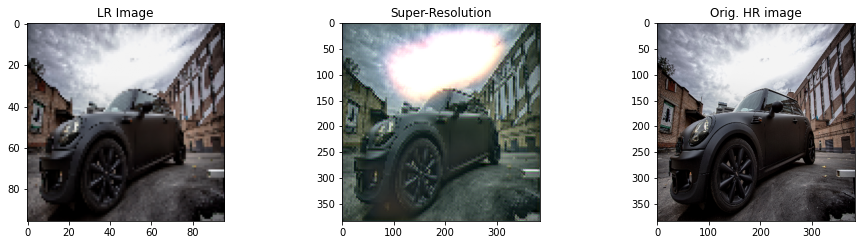

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Super-Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()